# **LoRA FINE-TUNING OF FLAN T5 BASE MODEL ON PINTEREST KEYWORD GENERATION**




# 1. Model Training

## 1.1 Installing Dependencies

In [ ]:
# First, uninstall conflicting packages and install compatible versions
!pip uninstall -y torch torchvision torchaudio transformers accelerate -q
!pip install torch==2.4.0 transformers==4.44.0 datasets==2.20.0 accelerate==0.33.0 scikit-learn -q

# Restart runtime after installation
import os
os.kill(os.getpid(), 9)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.3/797.3 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 1.2 Importing Packages

In [16]:
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    get_linear_schedule_with_warmup,
    DataCollatorForSeq2Seq
)
from peft import (
    LoraConfig,
    get_peft_model,
    TaskType,
    PeftModel,
    prepare_model_for_kbit_training
)
from google.colab import drive
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os
import random
import numpy as np
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from typing import List, Dict, Tuple
import re
import warnings
warnings.filterwarnings('ignore')

## 1.3 Configuration Class For LoRA Fine Tuning

In [2]:
class Config:
    """LoRA-optimized configuration for small dataset fine-tuning"""

    # Model settings
    MODEL_NAME = "google/flan-t5-base"

    MAX_INPUT_LEN = 256
    MAX_TARGET_LEN = 256

    # Training settings
    BATCH_SIZE = 4
    GRADIENT_ACCUMULATION_STEPS = 4
    LEARNING_RATE = 3e-4
    NUM_EPOCHS = 85
    WARMUP_RATIO = 0.1
    WEIGHT_DECAY = 0.01

    LORA_R = 16
    LORA_ALPHA = 32
    LORA_DROPOUT = 0.1
    LORA_TARGET_MODULES = ["q", "v", "k", "o", "wi", "wo"]

    # Generation settings
    TEMPERATURE = 0.8
    TOP_P = 0.95
    NUM_BEAMS = 6
    REPETITION_PENALTY = 1.8
    LENGTH_PENALTY = 1.1

    # Learning rate scheduling
    LR_SCHEDULER = "cosine"
    MIN_LR = 1e-6

    DRIVE_PATH = "/content/drive/MyDrive"
    MODEL_SAVE_PATH = f"{DRIVE_PATH}/pinterest-flan-t5-lora-improved-dataset-no-stopping-augmented"
    DATASET_PATH = "pinterest-data-augmented.json"

    SEED = 42
    PATIENCE = 10


## 1.4 Utility Functions

In [17]:
def set_seed(seed=42):
    """Set random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def mount_drive():
    """Mount Google Drive"""
    try:
        drive.mount('/content/drive')
        print("✅ Google Drive mounted successfully")
    except:
        print("⚠️ Could not mount Google Drive. Saving locally.")

mount_drive()

Mounted at /content/drive
✅ Google Drive mounted successfully


## 1.5 Dataset Class

In [4]:
class PinterestPersonalityDataset(Dataset):
    """Dataset for Pinterest personality keywords generation"""

    def __init__(self, data, tokenizer, config, max_input_len=128, max_target_len=256):
        self.data = data
        self.tokenizer = tokenizer
        self.max_input_len = max_input_len
        self.max_target_len = max_target_len
        self.config = config

    def __len__(self):
        return len(self.data)

    def _create_enhanced_input(self, item):
        """Create more informative input text"""
        name = item['name']
        culture = item.get('culture_region', '')
        role = item.get('role', '')
        period = item.get('time_period', '')
        bio = item.get('bio', '')

        input_parts = [
            f"Generate Pinterest keywords for {name}",
        ]

        context_parts = []
        if culture:
            context_parts.append(f"Culture: {culture}")
        if role:
            context_parts.append(f"Role: {role}")
        if period:
            context_parts.append(f"Period: {period}")
        if bio:
          context_parts.append(f"Bio: {bio}")

        if context_parts:
            input_parts.append(" | ".join(context_parts))

        # Instruction for Pinterest optimization
        input_parts.append("Keywords should be visual, searchable on Pinterest, and capture their aesthetic essence. The Culture, Role, Period and bio give important information about the personality. Take them into account when generating keywords")

        return " - ".join(input_parts)

    def __getitem__(self, idx):
        item = self.data[idx]

        input_text = self._create_enhanced_input(item)
        target_text = item['target_text']

        # Tokenize input
        input_encoding = self.tokenizer(
            input_text,
            max_length=self.config.MAX_INPUT_LEN,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Tokenize target
        target_encoding = self.tokenizer(
            target_text,
            max_length=self.config.MAX_TARGET_LEN,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        labels = target_encoding['input_ids'].squeeze()
        labels[labels == self.tokenizer.pad_token_id] = -100

        return {
            'input_ids': input_encoding['input_ids'].squeeze(),
            'attention_mask': input_encoding['attention_mask'].squeeze(),
            'labels': labels
        }


## 1.6 Evaluation Metrics

In [7]:
class PinterestEvaluator:
    """Evaluate the quality of generated Pinterest keywords"""

    def __init__(self):
        self.visual_terms = [
            'aesthetic', 'style', 'color', 'texture', 'pattern', 'design',
            'art', 'visual', 'mood', 'vibe', 'look', 'fashion', 'decor',
            'palette', 'tone', 'hue', 'shade', 'photography', 'image'
        ]

        self.pinterest_terms = [
            'board', 'pin', 'inspiration', 'diy', 'craft', 'vintage',
            'rustic', 'minimalist', 'boho', 'chic', 'glam', 'cozy',
            'aesthetic', 'mood', 'vibe', 'style', 'ideas', 'inspo'
        ]

    def calculate_keyword_diversity(self, keywords_list: List[str]) -> float:
        """Calculate diversity score for generated keywords"""

        all_keywords = []
        for keywords in keywords_list:
            all_keywords.extend([k.strip() for k in keywords.split(',')])

        unique_keywords = set(all_keywords)
        diversity_score = len(unique_keywords) / len(all_keywords) if all_keywords else 0

        return diversity_score

    def evaluate_quality(self, generated_text: str) -> Dict[str, float]:
        """Evaluate the Pinterest-specific quality of generated keywords"""

        keywords = [k.strip().lower() for k in generated_text.split(',')]

        # Visual score
        visual_score = sum(1 for keyword in keywords
                          for term in self.visual_terms if term in keyword) / len(keywords)

        # Pinterest score
        pinterest_score = sum(1 for keyword in keywords
                             for term in self.pinterest_terms if term in keyword) / len(keywords)

        # Length and diversity
        avg_keyword_length = np.mean([len(k) for k in keywords])
        keyword_diversity = len(set(keywords)) / len(keywords)

        return {
            'visual_score': visual_score,
            'pinterest_score': pinterest_score,
            'avg_keyword_length': avg_keyword_length,
            'keyword_diversity': keyword_diversity,
            'total_keywords': len(keywords)
        }

## 1.7 LoRA Training Class

In [8]:
class PinterestLoRATrainer:
    """LoRA training class for Pinterest keyword generation"""

    def __init__(self, config: Config):
        self.config = config
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        self.evaluator = PinterestEvaluator()

        print(f"Loading base model: {config.MODEL_NAME}")
        self.tokenizer = AutoTokenizer.from_pretrained(config.MODEL_NAME)
        self.base_model = AutoModelForSeq2SeqLM.from_pretrained(
            config.MODEL_NAME,
            torch_dtype=torch.float32
        ).to(self.device)

        lora_config = LoraConfig(
            r=config.LORA_R,
            lora_alpha=config.LORA_ALPHA,
            target_modules=config.LORA_TARGET_MODULES,
            lora_dropout=config.LORA_DROPOUT,
            bias="none",
            task_type=TaskType.SEQ_2_SEQ_LM,
        )

        self.model = get_peft_model(self.base_model, lora_config)

        self.model.print_trainable_parameters()

        print(f"✅ LoRA model loaded with {self.count_parameters():,} trainable parameters")

    def count_parameters(self):
        """Count trainable parameters"""
        return sum(p.numel() for p in self.model.parameters() if p.requires_grad)

    def prepare_data(self, data_path: str) -> Tuple[List[Dict], List[Dict]]:
        """Load and prepare the dataset"""

        print("\n📂 Loading dataset...")
        with open(data_path, 'r') as f:
            data = json.load(f)

        print(f"Loaded {len(data)} personalities")

        cleaned_data = self._validate_data(data)

        train_data, val_data = train_test_split(
            cleaned_data,
            test_size=0.15,
            random_state=self.config.SEED
        )

        print(f"Training samples: {len(train_data)}")
        print(f"Validation samples: {len(val_data)}")

        return train_data, val_data

    def _validate_data(self, data: List[Dict]) -> List[Dict]:
        """Validate and clean the dataset"""

        cleaned_data = []
        required_fields = ['name', 'target_text']

        for item in data:
            if all(field in item for field in required_fields):
                cleaned_item = {}
                for key, value in item.items():
                    if isinstance(value, str):
                        cleaned_item[key] = value.strip()
                    else:
                        cleaned_item[key] = value

                keywords = [k.strip() for k in cleaned_item['target_text'].split(',') if k.strip()]
                cleaned_item['target_text'] = ', '.join(keywords)

                cleaned_item.setdefault('culture_region', '')
                cleaned_item.setdefault('role', '')
                cleaned_item.setdefault('time_period', '')

                cleaned_data.append(cleaned_item)

        return cleaned_data

    def train(self, train_data: List[Dict], val_data: List[Dict]):
        """Main LoRA training loop"""

        # datasets
        train_dataset = PinterestPersonalityDataset(train_data, self.tokenizer, self.config)
        val_dataset = PinterestPersonalityDataset(val_data, self.tokenizer, self.config)

        # data collator
        data_collator = DataCollatorForSeq2Seq(
            self.tokenizer,
            model=self.model,
            label_pad_token_id=-100
        )

        # dataloaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=self.config.BATCH_SIZE,
            shuffle=True,
            collate_fn=data_collator,
            pin_memory=True
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=self.config.BATCH_SIZE,
            collate_fn=data_collator,
            pin_memory=True
        )

        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.config.LEARNING_RATE,
            weight_decay=self.config.WEIGHT_DECAY,
            eps=1e-8,
            betas=(0.9, 0.999)
        )

        # Learning rate scheduler
        total_steps = len(train_loader) * self.config.NUM_EPOCHS // self.config.GRADIENT_ACCUMULATION_STEPS
        warmup_steps = int(total_steps * self.config.WARMUP_RATIO)

        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_steps
        )

        history = defaultdict(list)
        best_val_loss = float('inf')
        patience_counter = 0

        print(f"\n🎯 Starting LoRA training...")
        print(f"Effective batch size: {self.config.BATCH_SIZE * self.config.GRADIENT_ACCUMULATION_STEPS}")
        print(f"Learning rate: {self.config.LEARNING_RATE}")
        print(f"Total training steps: {total_steps}")
        print(f"Warmup steps: {warmup_steps}")

        # Training loop
        for epoch in range(self.config.NUM_EPOCHS):
            print(f"\n{'='*60}")
            print(f"📍 Epoch {epoch + 1}/{self.config.NUM_EPOCHS}")
            print(f"{'='*60}")

            # Training phase
            train_loss = self._train_epoch(train_loader, optimizer, scheduler)
            history['train_loss'].append(train_loss)

            # Validation phase
            val_loss, val_examples, diversity_score = self._validate_epoch(val_loader)
            history['val_loss'].append(val_loss)
            history['diversity'].append(diversity_score)

            print(f"\n📊 Metrics:")
            print(f"Training Loss: {train_loss:.4f}")
            print(f"Validation Loss: {val_loss:.4f}")
            print(f"Keyword Diversity: {diversity_score:.4f}")
            print(f"Learning Rate: {scheduler.get_last_lr()[0]:.2e}")

            self._show_examples(val_examples)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                self._save_model("best")
                patience_counter = 0
                print(f"🎉 New best model saved! Val Loss: {val_loss:.4f}")
            else:
                patience_counter += 1

            # Early stopping
            # if patience_counter >= self.config.PATIENCE:
            #     print(f"\n⚠️ Early stopping at epoch {epoch + 1}")
            #     break

        self._save_model("final")

        self._plot_history(history)

        return history

    def _train_epoch(self, train_loader, optimizer, scheduler):
        """Training epoch for LoRA"""

        self.model.train()
        total_loss = 0
        progress_bar = tqdm(train_loader, desc="Training")

        optimizer.zero_grad()

        for step, batch in enumerate(progress_bar):
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            labels = batch['labels'].to(self.device)

            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss / self.config.GRADIENT_ACCUMULATION_STEPS
            total_loss += loss.item() * self.config.GRADIENT_ACCUMULATION_STEPS

            loss.backward()

            if (step + 1) % self.config.GRADIENT_ACCUMULATION_STEPS == 0:
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()

            progress_bar.set_postfix({
                'loss': loss.item() * self.config.GRADIENT_ACCUMULATION_STEPS,
                'lr': scheduler.get_last_lr()[0]
            })

        return total_loss / len(train_loader)

    def _validate_epoch(self, val_loader):
        """Validation epoch"""

        self.model.eval()
        total_loss = 0
        all_generated = []
        val_examples = []

        total_batches = len(val_loader)
        example_batch_indices = random.sample(range(total_batches), min(3, total_batches))

        with torch.no_grad():
            for batch_idx, batch in enumerate(tqdm(val_loader, desc="Validation")):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                total_loss += outputs.loss.item()

                # Generate examples from selected batches
                if batch_idx in example_batch_indices:
                    batch_size = input_ids.size(0)
                    sample_indices = random.sample(range(batch_size), min(2, batch_size))

                    for i in sample_indices:
                        generated = self.model.generate(
                            input_ids=input_ids[i:i+1],
                            attention_mask=attention_mask[i:i+1],
                            max_length=self.config.MAX_TARGET_LEN,
                            num_beams=self.config.NUM_BEAMS,
                            temperature=self.config.TEMPERATURE,
                            do_sample=True,
                            top_p=self.config.TOP_P,
                            repetition_penalty=self.config.REPETITION_PENALTY,
                            length_penalty=self.config.LENGTH_PENALTY,
                            early_stopping=True,
                            pad_token_id=self.tokenizer.pad_token_id
                        )

                        input_text = self.tokenizer.decode(input_ids[i], skip_special_tokens=True)
                        generated_text = self.tokenizer.decode(generated[0], skip_special_tokens=True)
                        actual_text = self.tokenizer.decode(
                            labels[i][labels[i] != -100],
                            skip_special_tokens=True
                        )

                        val_examples.append({
                            'input': input_text,
                            'generated': generated_text,
                            'actual': actual_text
                        })

                        all_generated.append(generated_text)

        avg_loss = total_loss / len(val_loader)
        diversity_score = self.evaluator.calculate_keyword_diversity(all_generated)

        return avg_loss, val_examples, diversity_score

    def _show_examples(self, examples):
        """Display validation examples"""

        print(f"\n📝 Validation Examples ({len(examples)} total):")
        print("=" * 80)

        for i, ex in enumerate(examples, 1):
            input_parts = ex['input'].split(' - ')
            personality_info = input_parts[0] if input_parts else "Unknown"

            print(f"\n🎭 Example {i}: {personality_info}")
            print(f"📥 Input: {ex['input'][:100]}{'...' if len(ex['input']) > 100 else ''}")
            print(f"🎯 Generated: {ex['generated']}")
            print(f"✅ Expected: {ex['actual']}")

            quality = self.evaluator.evaluate_quality(ex['generated'])
            print(f"📊 Quality - Visual: {quality['visual_score']:.2f}, "
                  f"Pinterest: {quality['pinterest_score']:.2f}, "
                  f"Diversity: {quality['keyword_diversity']:.2f}")
            print("-" * 80)

    def _save_model(self, suffix):
        """Save LoRA model"""

        save_path = f"{self.config.MODEL_SAVE_PATH}-{suffix}"
        os.makedirs(save_path, exist_ok=True)

        self.model.save_pretrained(save_path)
        self.tokenizer.save_pretrained(save_path)

        print(f"💾 LoRA model saved to: {save_path}")

    def _plot_history(self, history):
        """Plot training history"""

        plt.figure(figsize=(15, 5))

        # Loss plot
        plt.subplot(1, 3, 1)
        plt.plot(history['train_loss'], label='Train Loss', marker='o')
        plt.plot(history['val_loss'], label='Val Loss', marker='s')
        plt.title('Training Progress')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        # Diversity plot
        plt.subplot(1, 3, 2)
        plt.plot(history['diversity'], label='Keyword Diversity', marker='d', color='green')
        plt.title('Generation Diversity')
        plt.xlabel('Epoch')
        plt.ylabel('Diversity Score')
        plt.legend()
        plt.grid(True)

        # Combined metrics
        plt.subplot(1, 3, 3)
        epochs = range(1, len(history['train_loss']) + 1)
        plt.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
        plt.plot(epochs, history['val_loss'], 'r-', label='Val Loss')
        plt.plot(epochs, history['diversity'], 'g--', label='Diversity')
        plt.title('All Metrics')
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.savefig(f'{self.config.DRIVE_PATH}/pinterest_lora_training_history.png', dpi=150)
        plt.show()

## 1.8 Inference Class

In [9]:
class PinterestLoRAGenerator:
    """Generate Pinterest keywords using LoRA fine-tuned model"""

    def __init__(self, model_path: str, base_model_name: str = "google/flan-t5-base"):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        print(f"Loading LoRA model from {model_path}...")

        self.tokenizer = AutoTokenizer.from_pretrained(model_path)

        base_model = AutoModelForSeq2SeqLM.from_pretrained(
            base_model_name,
            torch_dtype=torch.float32
        )

        self.model = PeftModel.from_pretrained(base_model, model_path).to(self.device)
        self.model.eval()

        self.evaluator = PinterestEvaluator()
        print("✅ LoRA model loaded successfully!")

    def generate(
        self,
        personality_name: str,
        role: str = "",
        culture_region: str = "",
        time_period: str = "",
        bio: str = "",
        num_variations: int = 1
    ) -> Dict:
        """Generate Pinterest keywords using LoRA model"""

        input_parts = [f"Generate Pinterest keywords for {personality_name}"]
        context_parts = []

        if culture_region:
            context_parts.append(f"Culture: {culture_region}")
        if role:
            context_parts.append(f"Role: {role}")
        if time_period:
            context_parts.append(f"Period: {time_period}")
        if bio:
            context_parts.append(f"Bio: {bio}")

        if context_parts:
            input_parts.append(" | ".join(context_parts))

        input_parts.append("Keywords should be visual, searchable on Pinterest, and capture their aesthetic essence. The Culture, Role, Period and bio give important information about the personality. Take them into account when generating keywords")

        prompt = " - ".join(input_parts)

        inputs = self.tokenizer(
            prompt,
            max_length=256,
            return_tensors='pt',
            truncation=True
        ).to(self.device)

        results = []

        for _ in range(num_variations):
            with torch.no_grad():
                outputs = self.model.generate(
                    **inputs,
                    max_length=300,
                    num_beams=8,
                    temperature=0.9,
                    do_sample=True,
                    top_p=0.95,
                    repetition_penalty=2.0,
                    length_penalty=1.2,
                    early_stopping=True,
                    no_repeat_ngram_size=2,
                )

            generated_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
            quality = self.evaluator.evaluate_quality(generated_text)

            results.append({
                'keywords': generated_text,
                'quality': quality
            })

        return {
            'personality': personality_name,
            'role': role,
            'culture_region': culture_region,
            'time_period': time_period,
            'variations': results
        }

## 1.9 Main Function Execution

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted successfully
Using device: cuda
Loading base model: google/flan-t5-base


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

trainable params: 4,620,288 || all params: 252,198,144 || trainable%: 1.8320
✅ LoRA model loaded with 4,620,288 trainable parameters

📂 Loading dataset...
Loaded 462 personalities
Training samples: 392
Validation samples: 70

🎯 Starting LoRA training...
Effective batch size: 16
Learning rate: 0.0003
Total training steps: 2082
Warmup steps: 208

📍 Epoch 1/85


Validation: 100%|██████████| 18/18 [00:08<00:00,  2.01it/s]



📊 Metrics:
Training Loss: 4.5815
Validation Loss: 4.3172
Keyword Diversity: 0.9333
Learning Rate: 3.46e-05

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Quintilian
📥 Input: Generate Pinterest keywords for Quintilian - Culture: Roman | Role: Philosopher | Period: Ancient | ...
🎯 Generated: Fabius Quintilianus, Philosopher
✅ Expected: roman classroom aesthetic | orator busts visual | toga-clad teacher | roman scholar aesthetic | roman scripts moodboard | golden quills | Institutio Oratoria | roman orator core
📊 Quality - Visual: 0.00, Pinterest: 0.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Napoleon Bonaparte
📥 Input: Generate Pinterest keywords for Napoleon Bonaparte - Culture: French | Role: Royalty | Period: 18th ...
🎯 Generated: Napoleon Bonaparte -lrb- 18th Century -rrb-
✅ Expected: french revolution | imperial laurel wreaths | battlefield glory |

Validation: 100%|██████████| 18/18 [00:12<00:00,  1.43it/s]



📊 Metrics:
Training Loss: 4.3902
Validation Loss: 3.9881
Keyword Diversity: 1.0000
Learning Rate: 6.92e-05

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for James Clerk Maxwell
📥 Input: Generate Pinterest keywords for James Clerk Maxwell - Culture: Scottish | Role: Physicist | Period: ...
🎯 Generated: James Clerk Maxwell was a Scottish physicist and mathematician who formulated the classical theory of electromagnetic radiation, uniting electricity, magnetism, and light into one framework.
✅ Expected: Victorian physics mood | industrial era aesthetics | chalkboard equations aesthetic | electromagnetic field diagrams | oil-lamp lit study | 19th century academia | parchment science notes | antique lab apparatus | electricity aesthetics
📊 Quality - Visual: 0.00, Pinterest: 0.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Neo
📥 Input: Generate Pinterest keywords

Validation: 100%|██████████| 18/18 [00:14<00:00,  1.28it/s]



📊 Metrics:
Training Loss: 4.0082
Validation Loss: 3.4342
Keyword Diversity: 0.6429
Learning Rate: 1.04e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Tony Stark
📥 Input: Generate Pinterest keywords for Tony Stark - Culture: American | Role: Inventor/Superhero | Period: ...
🎯 Generated: Inventor, superhero, science fiction, sci-fi
✅ Expected: fast cars and hard choices | futuristic workshop moodboard | holographic UI visuals | iron man suit schematics | tech genius style | avengers core energy | high-tech billionaire aesthetic | modern mythmaker vibe | red and gold arc reactor glow
📊 Quality - Visual: 0.00, Pinterest: 0.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Al-Biruni
📥 Input: Generate Pinterest keywords for Al-Biruni - Culture: Persian | Role: Scientist | Period: Medieval Is...
🎯 Generated: Al-Biruni was a brilliant Persian scientist who made

Validation: 100%|██████████| 18/18 [00:14<00:00,  1.28it/s]



📊 Metrics:
Training Loss: 3.4877
Validation Loss: 3.0234
Keyword Diversity: 1.0000
Learning Rate: 1.38e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Medusa
📥 Input: Generate Pinterest keywords for Medusa - Culture: Greek | Role: Mythology | Period: Ancient | Bio: M...
🎯 Generated: aphrodisiacs | greek mythology | gyroglyphics | ancient greek mythology | neanderthal mythology | gyroglyphics
✅ Expected: snake hair aesthetics | stone gaze | dark elegance | gorgon power | shattered statues | golden serpent jewelry aesthetics | mythic horror moodboard | Medusa core
📊 Quality - Visual: 0.00, Pinterest: 0.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Seneca
📥 Input: Generate Pinterest keywords for Seneca - Culture: Roman | Role: Philosopher, Statesman | Period: Anc...
🎯 Generated: adversity | ecclesiastical aesthetics | stoicism | ecclesiastical philosoph

Validation: 100%|██████████| 18/18 [00:13<00:00,  1.33it/s]



📊 Metrics:
Training Loss: 3.1695
Validation Loss: 2.8315
Keyword Diversity: 1.0000
Learning Rate: 1.73e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Aphrodite
📥 Input: Generate Pinterest keywords for Aphrodite - Culture: Greek | Role: Mythology | Period: Ancient | Bio...
🎯 Generated: aphrodite moodboard | greek sea foam | romantic allure | aphrodite statues | aphrodite robes | gypsies moodboard
✅ Expected: aphrodite core | sea shell aesthetic | goddess of love moodboard | soft pastels theme | sea foam imagery | grecian robes look | classical beauty moodboard | rose petals aesthetic
📊 Quality - Visual: 1.00, Pinterest: 2.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Al-Ghazali
📥 Input: Generate Pinterest keywords for Al-Ghazali - Culture: Persian | Role: Philosopher | Period: Islamic ...
🎯 Generated: al-ghazali islamic philosophy | islamic golden ag

Validation: 100%|██████████| 18/18 [00:15<00:00,  1.19it/s]



📊 Metrics:
Training Loss: 3.0035
Validation Loss: 2.7236
Keyword Diversity: 1.0000
Learning Rate: 2.08e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Hermes
📥 Input: Generate Pinterest keywords for Hermes - Culture: Greek | Role: Mythology | Period: Ancient | Bio: H...
🎯 Generated: gypsies | gypsies mythology | gypsies magic | gypsies sandals | gypsies art | gypsies rituals | gypsies mythology | gypsies magic | gypsies mythology
✅ Expected: caduceus symbol | trickster charm moodboard | golden travel cloak look | ancient greek roads aesthetic | winged sandals theme board | messenger aesthetic | hermes core | ancient travel theme
📊 Quality - Visual: 1.00, Pinterest: 0.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Michael Faraday
📥 Input: Generate Pinterest keywords for Michael Faraday - Culture: British | Role: Scientist | Period: Indus...
🎯 Generated

Validation: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]



📊 Metrics:
Training Loss: 2.8825
Validation Loss: 2.6482
Keyword Diversity: 1.0000
Learning Rate: 2.42e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Neo
📥 Input: Generate Pinterest keywords for Neo - Culture: American Fiction | Role: The One | Period: Modern Sci...
🎯 Generated: keanu reeves aesthetic | computer hacking moodboard | modern sci-fi aesthetic | neophyte mythology | neoglyphics aesthetic | neoglyphics aesthetic | neoglyphics aesthetic
✅ Expected: dystopian future ambiance | neo's journey | philosophical sci-fi moodboard | cyberpunk aesthetics | rebellion against machines | virtual reality vibe | sci-fi action sequences | matrix code rain aesthetics
📊 Quality - Visual: 2.00, Pinterest: 3.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Hermes
📥 Input: Generate Pinterest keywords for Hermes - Culture: Greek | Role: Mythology | Period: Ancient

Validation: 100%|██████████| 18/18 [00:14<00:00,  1.24it/s]



📊 Metrics:
Training Loss: 2.7897
Validation Loss: 2.5904
Keyword Diversity: 1.0000
Learning Rate: 2.77e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Ibn al-Haytham
📥 Input: Generate Pinterest keywords for Ibn al-Haytham - Culture: Persian | Role: Scientist | Period: Mediev...
🎯 Generated: islamic science aesthetics | golden age of optics | al-Haytham's vision | islamic science moodboard | islamic science aesthetics | islamic science aesthetics | islamic science aesthetics
✅ Expected: islamic optics aesthetic | golden age of islam | light refraction diagrams aesthetic | ancient camera obscura | persian calligraphy aesthetics | persian architecture | islamic architecture theme | persian astronomy moodboard | glowing manuscripts
📊 Quality - Visual: 2.00, Pinterest: 3.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Al-Biruni
📥 Input: Generate Pinterest k

Validation: 100%|██████████| 18/18 [00:21<00:00,  1.17s/it]



📊 Metrics:
Training Loss: 2.7172
Validation Loss: 2.5208
Keyword Diversity: 1.0000
Learning Rate: 2.99e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Friedrich Nietzsche
📥 Input: Generate Pinterest keywords for Friedrich Nietzsche - Culture: German | Role: Philosopher | Period: ...
🎯 Generated: recurrence aesthetics | eternal recurrence moodboard | transcendence aesthetics | Übermensch aesthetics | postmodernism aesthetics | god is dead aesthetics
✅ Expected: lone thinkers vibe | vintage philosophy books | overgrown ruins aesthetics | Existential nihilism | typewritten aphorisms | existentialism | God is dead quote | mountain solitude mood
📊 Quality - Visual: 2.00, Pinterest: 3.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for William Shakespeare
📥 Input: Generate Pinterest keywords for William Shakespeare - Culture: English | Role: Playwright | Period:

Validation: 100%|██████████| 18/18 [00:17<00:00,  1.05it/s]



📊 Metrics:
Training Loss: 2.6093
Validation Loss: 2.4598
Keyword Diversity: 1.0000
Learning Rate: 2.95e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Queen Elizabeth II
📥 Input: Generate Pinterest keywords for Queen Elizabeth II - Culture: British | Role: Queen | Period: World ...
🎯 Generated: british monarchy | post-war era british monarchy | british royal crown | post-war era british empire | british monarchy moodboard | world war ii theme | british royalty aesthetics
✅ Expected: crown jewels moodboard | wartime service uniform | 1950s england vibes | british crown aura | british monarchy ambience | birmingham palace aesthetic | corgi companionship | windsor castle aesthetics | christianity moodboard | british royal coronation
📊 Quality - Visual: 2.00, Pinterest: 3.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Mahatma Gandhi
📥 Input: Generate Pint

Validation: 100%|██████████| 18/18 [00:17<00:00,  1.05it/s]



📊 Metrics:
Training Loss: 2.5413
Validation Loss: 2.4087
Keyword Diversity: 1.0000
Learning Rate: 2.91e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Ramses II
📥 Input: Generate Pinterest keywords for Ramses II - Culture: Egyptian | Role: King | Period: Ancient | Bio: ...
🎯 Generated: egyptian pharaoh aesthetics | egyptian king moodboard | ancient egyptian architecture | egyptian pharaoh aesthetics | egyptian dynasty aesthetics | egyptian empire aesthetics | ancient egyptian hieroglyphic art | egyptian king aesthetics
✅ Expected: egyptian dynasty aesthetic | egyptian civilization aesthetic | stone colossi | warrior pharaoh aura | divine sun crown ambience | egyptian war moodboards | egyptian king aesthetic | hieroglyphic inscriptions | ancient egyptian civilization aesthetic
📊 Quality - Visual: 3.00, Pinterest: 3.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest key

Validation: 100%|██████████| 18/18 [00:15<00:00,  1.18it/s]



📊 Metrics:
Training Loss: 2.4664
Validation Loss: 2.3465
Keyword Diversity: 1.0000
Learning Rate: 2.87e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Aphrodite
📥 Input: Generate Pinterest keywords for Aphrodite - Culture: Greek | Role: Mythology | Period: Ancient | Bio...
🎯 Generated: greek sea foam aesthetics | aphrodite moodboard | sea foam beauty | roses and doves aesthetic | romantic allure moodboard | sea foam aesthetics
✅ Expected: aphrodite core | sea shell aesthetic | rose petals aesthetic | classical beauty moodboard | soft pastels theme | sea foam imagery | grecian robes look | goddess of love moodboard
📊 Quality - Visual: 2.00, Pinterest: 3.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Frida Kahlo
📥 Input: Generate Pinterest keywords for Frida Kahlo - Culture: Mexican | Role: Painter | Period: 20th Centur...
🎯 Generated: mexican folk art 

Validation: 100%|██████████| 18/18 [00:15<00:00,  1.16it/s]



📊 Metrics:
Training Loss: 2.4048
Validation Loss: 2.3181
Keyword Diversity: 1.0000
Learning Rate: 2.83e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Poseidon
📥 Input: Generate Pinterest keywords for Poseidon - Culture: Greek | Role: Mythology | Period: Ancient | Bio:...
🎯 Generated: sea trident aesthetic | trident aura | ocean waves moodboard | trident core | underwater palace aesthetics | greek mythology moodboard
✅ Expected: greek sea temples | ocean deity | aquatic rage visual | trident power moodboard | seafoam aesthetic | stormy seas visual | underwater palace aesthetic | greek mythology moodboard | poseidon core | hippocampus creatures theme
📊 Quality - Visual: 2.00, Pinterest: 3.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Medusa
📥 Input: Generate Pinterest keywords for Medusa - Culture: Greek | Role: Mythology | Period: Ancient | Bio: M...

Validation: 100%|██████████| 18/18 [00:13<00:00,  1.33it/s]



📊 Metrics:
Training Loss: 2.3437
Validation Loss: 2.2681
Keyword Diversity: 1.0000
Learning Rate: 2.80e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Galen
📥 Input: Generate Pinterest keywords for Galen - Culture: Roman | Role: Philosopher | Period: Ancient | Bio: ...
🎯 Generated: roman medicine aesthetics | ancient greek anatomy moodboard | ancient greek medicine aesthetics | ancient greek medicine aesthetics | ancient greek medicine aesthetics | ancient greek medicine aesthetics | ancient greek medicine aesthetic
✅ Expected: anatomical scrolls theme board | roman healing temples | roman apothecary jars aesthetic | surgical tools aesthetic | roman physician look | classical biology core | olive oil infusions | marble dissection table | ancient roman medicine theme board
📊 Quality - Visual: 2.00, Pinterest: 3.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keyword

Validation: 100%|██████████| 18/18 [00:14<00:00,  1.26it/s]



📊 Metrics:
Training Loss: 2.2961
Validation Loss: 2.2197
Keyword Diversity: 1.0000
Learning Rate: 2.76e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Galen
📥 Input: Generate Pinterest keywords for Galen - Culture: Roman | Role: Philosopher | Period: Ancient | Bio: ...
🎯 Generated: roman medicine aesthetics | roman anatomy diagrams | ancient greek medicine aesthetics | ancient greek medicine aesthetics | ancient greek medicine aesthetics | ancient greek medicine aesthetics | ancient greek medicine aesthetics | ancient greek medicine aesthetics
✅ Expected: anatomical scrolls theme board | roman healing temples | roman apothecary jars aesthetic | surgical tools aesthetic | roman physician look | classical biology core | olive oil infusions | marble dissection table | ancient roman medicine theme board
📊 Quality - Visual: 1.00, Pinterest: 1.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2

Validation: 100%|██████████| 18/18 [00:15<00:00,  1.16it/s]



📊 Metrics:
Training Loss: 2.2343
Validation Loss: 2.1938
Keyword Diversity: 1.0000
Learning Rate: 2.72e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Tony Stark
📥 Input: Generate Pinterest keywords for Tony Stark - Culture: American | Role: Inventor/Superhero | Period: ...
🎯 Generated: iron man aesthetic | futuristic sci-fi moodboard | nintendo universe aesthetics | supervillain aesthetics | futuristic science vibe | black-and-white visuals | cyberpunk aesthetics | futuristic superheroes
✅ Expected: fast cars and hard choices | futuristic workshop moodboard | holographic UI visuals | iron man suit schematics | tech genius style | avengers core energy | high-tech billionaire aesthetic | modern mythmaker vibe | red and gold arc reactor glow
📊 Quality - Visual: 4.00, Pinterest: 4.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Al-Biruni
📥 Input: Generate

Validation: 100%|██████████| 18/18 [00:16<00:00,  1.09it/s]



📊 Metrics:
Training Loss: 2.1835
Validation Loss: 2.1302
Keyword Diversity: 1.0000
Learning Rate: 2.68e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Napoleon Bonaparte
📥 Input: Generate Pinterest keywords for Napoleon Bonaparte - Culture: French | Role: Royalty | Period: 18th ...
🎯 Generated: Napoleon Bonaparte's robes | french revolution aesthetics | golden robes moodboard | French Revolution aesthetics | military campaigning moodboard | 18th century france aesthetics | french revolution aesthetics
✅ Expected: french revolution | imperial laurel wreaths | battlefield glory | french kingdom aesthetic | napoleonic era | conquest maps moodboard | neoclassical power | french battlefield art | napolean army military uniforms aesthetics | french empire ambience | french exile aesthetics
📊 Quality - Visual: 3.00, Pinterest: 3.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinte

Validation: 100%|██████████| 18/18 [00:13<00:00,  1.32it/s]



📊 Metrics:
Training Loss: 2.1219
Validation Loss: 2.1162
Keyword Diversity: 1.0000
Learning Rate: 2.64e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for James Clerk Maxwell
📥 Input: Generate Pinterest keywords for James Clerk Maxwell - Culture: Scottish | Role: Physicist | Period: ...
🎯 Generated: scottish science aesthetics | industrial era aesthetics | classical theory of electromagnetic radiation | scottish scientist moodboard | vintage microscopes | scottish laboratory aesthetics
✅ Expected: Victorian physics mood | industrial era aesthetics | chalkboard equations aesthetic | electromagnetic field diagrams | oil-lamp lit study | 19th century academia | parchment science notes | antique lab apparatus | electricity aesthetics
📊 Quality - Visual: 2.00, Pinterest: 4.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Michael Faraday
📥 Input: Generate Pintere

Validation: 100%|██████████| 18/18 [00:17<00:00,  1.01it/s]



📊 Metrics:
Training Loss: 2.0938
Validation Loss: 2.0779
Keyword Diversity: 1.0000
Learning Rate: 2.60e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Batman
📥 Input: Generate Pinterest keywords for Batman - Culture: American Fiction | Role: Vigilante | Period: Moder...
🎯 Generated: Batman aesthetics | Gotham City aesthetics | bat-themed armor | dc comics moodboard | Gotham City aesthetics | vigilante crime scene
✅ Expected: gothic skyscrapers | bat signal theme | dark knight silhouette | noir crime scenes | black cape aesthetic | urban shadows | noir aesthetics | Gotham City aesthetic | vigilante justice moodboard
📊 Quality - Visual: 2.00, Pinterest: 3.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Al-Ghazali
📥 Input: Generate Pinterest keywords for Al-Ghazali - Culture: Persian | Role: Philosopher | Period: Islamic ...
🎯 Generated: islamic golden ag

Validation: 100%|██████████| 18/18 [00:13<00:00,  1.34it/s]



📊 Metrics:
Training Loss: 2.0409
Validation Loss: 2.0649
Keyword Diversity: 1.0000
Learning Rate: 2.56e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Frida Kahlo
📥 Input: Generate Pinterest keywords for Frida Kahlo - Culture: Mexican | Role: Painter | Period: 20th Centur...
🎯 Generated: surrealism aesthetics | mexican folk art | surida kahlo's self-portraits | mexican culture moodboard | mexican folk art
✅ Expected: mexican folk art | Kahlo aesthetics | modern art aesthetics | frida kahlo self-portraits | folk surrealism | mexican heritage theme board | mexican identity | floral headpieces | embroidered corsets vibe | vibrant colors | mexican culture moodboard
📊 Quality - Visual: 3.00, Pinterest: 3.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Ares
📥 Input: Generate Pinterest keywords for Ares - Culture: Greek | Role: Mythology | Period: Ancient | B

Validation: 100%|██████████| 18/18 [00:15<00:00,  1.18it/s]



📊 Metrics:
Training Loss: 2.0091
Validation Loss: 2.0265
Keyword Diversity: 1.0000
Learning Rate: 2.53e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Porphyry
📥 Input: Generate Pinterest keywords for Porphyry - Culture: Roman | Role: Philosopher | Period: Ancient | Bi...
🎯 Generated: neoplatonism aesthetics | roman philosophy moodboard | metaphysics aesthetic | neoplatonism aesthetic | ancient rome aesthetics | marble temples theme board | neoplatonism aesthetics
✅ Expected: neoplatonism aesthetic | roman aesthetics | sacred geometry moodboard | divine aesthetics | geometric mosaics | theurgy symbols | quill art | philosopher's study vibe | metaphysical art moodboard
📊 Quality - Visual: 2.00, Pinterest: 3.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Carl Sagan
📥 Input: Generate Pinterest keywords for Carl Sagan - Culture: American | Role: Astronome

Validation: 100%|██████████| 18/18 [00:14<00:00,  1.20it/s]



📊 Metrics:
Training Loss: 1.9384
Validation Loss: 1.9897
Keyword Diversity: 1.0000
Learning Rate: 2.49e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Michael Faraday
📥 Input: Generate Pinterest keywords for Michael Faraday - Culture: British | Role: Scientist | Period: Indus...
🎯 Generated: faraday cage aesthetics | industrial era aesthetics | vintage laboratory aesthetics | Victorian science moodboard | early electric motors | 19th century science | vintage laboratory aesthetics
✅ Expected: vintage laboratory aesthetic | industrial era aesthetics | vintage copper coils | Faraday cage inspiration | Victorian scientific drawings | electricity aesthetics | rustic lab vibes | 19th century science | parchment science notes
📊 Quality - Visual: 2.00, Pinterest: 4.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Neo
📥 Input: Generate Pinterest keywords for Ne

Validation: 100%|██████████| 18/18 [00:15<00:00,  1.19it/s]



📊 Metrics:
Training Loss: 1.9154
Validation Loss: 1.9498
Keyword Diversity: 1.0000
Learning Rate: 2.45e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Carl Sagan
📥 Input: Generate Pinterest keywords for Carl Sagan - Culture: American | Role: Astronomer and Science Commun...
🎯 Generated: cosmic exploration | poetic reflections moodboard | cosmic wonder aesthetics | cosmic wonder aesthetics | cosmic reflections | pale blue dot aesthetics | cosmic wonder aesthetics
✅ Expected: cosmic wonder aesthetic | pale blue dot melancholy | 80s stargazing moodboard | retro nasa visuals | poetic astrophysics | vhs cosmos documentary vibe | golden record nostalgia | interstellar aesthetics | universe in a grain of sand | carl sagan stardust aesthetic
📊 Quality - Visual: 2.00, Pinterest: 3.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Porphyry
📥 Input: Generate Pinter

Validation: 100%|██████████| 18/18 [00:14<00:00,  1.24it/s]



📊 Metrics:
Training Loss: 1.8912
Validation Loss: 1.9270
Keyword Diversity: 1.0000
Learning Rate: 2.41e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Carl Sagan
📥 Input: Generate Pinterest keywords for Carl Sagan - Culture: American | Role: Astronomer and Science Commun...
🎯 Generated: cosmic wonder aesthetics | cosmic reflection moodboard | pale blue dot aesthetics | cosmic exploration moodboard | cosmic wonder aesthetics | cosmic wisdom aesthetics
✅ Expected: vhs cosmos documentary vibe | carl sagan stardust aesthetic | 80s stargazing moodboard | golden record nostalgia | interstellar aesthetics | retro nasa visuals | cosmic wonder aesthetic | pale blue dot melancholy | poetic astrophysics | universe in a grain of sand
📊 Quality - Visual: 2.00, Pinterest: 3.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Tutankhamun
📥 Input: Generate Pinterest keywo

Validation: 100%|██████████| 18/18 [00:14<00:00,  1.20it/s]



📊 Metrics:
Training Loss: 1.8424
Validation Loss: 1.9278
Keyword Diversity: 1.0000
Learning Rate: 2.37e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Claude Shannon
📥 Input: Generate Pinterest keywords for Claude Shannon - Culture: American | Role: Mathematician/Engineer | ...
🎯 Generated: vintage computing aesthetics | mid-20th century america ambience | digital revolution aesthetics | cyberpunk science moodboard | information theory aesthetics | late 20th century america ambience
✅ Expected: 1950s ivy league thinker vibe | vintage circuit board diagrams | information entropy aesthetic | analog meets digital brilliance | mid-century lab geekcore | binary code aesthetic | digital revolution roots | mathematical elegance moodboard
📊 Quality - Visual: 2.00, Pinterest: 4.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Friedrich Nietzsche
📥 Input: Generat

Validation: 100%|██████████| 18/18 [00:15<00:00,  1.18it/s]



📊 Metrics:
Training Loss: 1.8074
Validation Loss: 1.8818
Keyword Diversity: 1.0000
Learning Rate: 2.33e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Porphyry
📥 Input: Generate Pinterest keywords for Porphyry - Culture: Roman | Role: Philosopher | Period: Ancient | Bi...
🎯 Generated: neoplatonism aesthetics | roman philosophy moodboard | ancient rome aesthetics | marble temples theme board | neoplatonism aesthetics | philosophical reflections moodboard | golden quills | metaphysics aesthetic | neoplatonism aesthetics
✅ Expected: neoplatonism aesthetic | roman aesthetics | sacred geometry moodboard | divine aesthetics | geometric mosaics | theurgy symbols | quill art | philosopher's study vibe | metaphysical art moodboard
📊 Quality - Visual: 2.00, Pinterest: 3.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Lucretius
📥 Input: Generate Pinterest keyword

Validation: 100%|██████████| 18/18 [00:15<00:00,  1.19it/s]



📊 Metrics:
Training Loss: 1.7698
Validation Loss: 1.8581
Keyword Diversity: 1.0000
Learning Rate: 2.30e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for William Shakespeare
📥 Input: Generate Pinterest keywords for William Shakespeare - Culture: English | Role: Playwright | Period: ...
🎯 Generated: renaissance drama | elizabethan theatre | renaissance literature moodboard | renaissance drama | hamlet aesthetic | macbeth aesthetic | renaissance theatre | elizabethan theatre ambience | renaissance poetry | renaissance drama
✅ Expected: globe theatre ambience | dramatic tragedy moodboard | elizabethan england | renaissance poetry | quill and parchment | elizabethan theater | macbeth themes | literary genius aesthetic | shakespearean quotes moodboard | romeo and juliet aesthetics | hamlet themes | renaissance drama
📊 Quality - Visual: 2.00, Pinterest: 3.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 

Validation: 100%|██████████| 18/18 [00:14<00:00,  1.28it/s]



📊 Metrics:
Training Loss: 1.7504
Validation Loss: 1.8463
Keyword Diversity: 1.0000
Learning Rate: 2.26e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Galen
📥 Input: Generate Pinterest keywords for Galen - Culture: Roman | Role: Philosopher | Period: Ancient | Bio: ...
🎯 Generated: roman anatomy diagrams | ancient rome aesthetics | roman physician aesthetic | roman philosophy moodboard | roman scientific notebooks | roman medicine aesthetic | ancient england aesthetic
✅ Expected: anatomical scrolls theme board | roman healing temples | roman apothecary jars aesthetic | surgical tools aesthetic | roman physician look | classical biology core | olive oil infusions | marble dissection table | ancient roman medicine theme board
📊 Quality - Visual: 2.00, Pinterest: 3.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Quintilian
📥 Input: Generate Pinterest keyw

Validation: 100%|██████████| 18/18 [00:14<00:00,  1.24it/s]



📊 Metrics:
Training Loss: 1.7047
Validation Loss: 1.8024
Keyword Diversity: 1.0000
Learning Rate: 2.22e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Hayao Miyazaki
📥 Input: Generate Pinterest keywords for Hayao Miyazaki - Culture: Japanese | Role: Animator/Director | Perio...
🎯 Generated: gibli animations aesthetics | fairy landscapes moodboard | hippocampus reflections | animated film noir aesthetics | spiritual away aesthetics | hippocampus reflections | my neighbor toto theme | hippocampus reflections
✅ Expected: ghibli animations aesthetics | childhood wonder and nostalgia | Ghibli film stills moodboard | whimsical animation aesthetic | magical realism vibes | Spirited Away aesthetics | lush landscapes and detailed worlds | hand-drawn artistry
📊 Quality - Visual: 2.00, Pinterest: 3.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Ibn al-Haytham
📥 

Validation: 100%|██████████| 18/18 [00:18<00:00,  1.05s/it]



📊 Metrics:
Training Loss: 1.6840
Validation Loss: 1.8040
Keyword Diversity: 1.0000
Learning Rate: 2.18e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Cleopatra
📥 Input: Generate Pinterest keywords for Cleopatra - Culture: Egyptian | Role: Royalty | Period: Ptolemaic Dy...
🎯 Generated: Ptolemaic dynasty aesthetic | egyptian queen moodboard | egyptian hieroglyphic art | egyptian royalty aesthetic | egyptian civilization aesthetic | egyptian calligraphy moodboard | egyptian queen aesthetic | egyptian history aesthetic | egyptian palace ambience | egyptian empire aesthetic
✅ Expected: Egyptian silk robes | egyptian queen aesthetic | ancient egyptian jewelery | golden diadem | egyptian civilization aesthetic | lapis jewelry | Nile river ambience | papyrus scrolls moodboard | ptolemaic dynasty moodboard | egyptian hieroglyphic art | pyramid sunset ambience | kohl eyeliner
📊 Quality - Visual: 3.00, Pinterest: 3.00, Diversity: 1.00
------------------------

Validation: 100%|██████████| 18/18 [00:17<00:00,  1.03it/s]



📊 Metrics:
Training Loss: 1.6565
Validation Loss: 1.7648
Keyword Diversity: 1.0000
Learning Rate: 2.14e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for James Clerk Maxwell
📥 Input: Generate Pinterest keywords for James Clerk Maxwell - Culture: Scottish | Role: Physicist | Period: ...
🎯 Generated: scottish science aesthetic | industrial era aesthetics | candlelit science moodboard | vintage laboratory aesthetic | Victorian science aesthetic | classical physics aesthetic | electricity aesthetic | steampunk science vibe | mechanical calculator aesthetic
✅ Expected: Victorian physics mood | industrial era aesthetics | chalkboard equations aesthetic | electromagnetic field diagrams | oil-lamp lit study | 19th century academia | parchment science notes | antique lab apparatus | electricity aesthetics
📊 Quality - Visual: 3.00, Pinterest: 5.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Gene

Validation: 100%|██████████| 18/18 [00:17<00:00,  1.00it/s]



📊 Metrics:
Training Loss: 1.6248
Validation Loss: 1.7453
Keyword Diversity: 1.0000
Learning Rate: 2.10e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Michael Faraday
📥 Input: Generate Pinterest keywords for Michael Faraday - Culture: British | Role: Scientist | Period: Indus...
🎯 Generated: faraday cage aesthetic | industrial era aesthetics | 19th century science | vintage lab aesthetic | vintage laboratory aesthetic | Victorian science moodboard | 18th century science | vintage laboratory aesthetic | industrial era aesthetics
✅ Expected: vintage laboratory aesthetic | industrial era aesthetics | vintage copper coils | Faraday cage inspiration | Victorian scientific drawings | electricity aesthetics | rustic lab vibes | 19th century science | parchment science notes
📊 Quality - Visual: 2.00, Pinterest: 4.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for

Validation: 100%|██████████| 18/18 [00:15<00:00,  1.16it/s]



📊 Metrics:
Training Loss: 1.6000
Validation Loss: 1.7373
Keyword Diversity: 1.0000
Learning Rate: 2.07e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Wu Daozi
📥 Input: Generate Pinterest keywords for Wu Daozi - Culture: Chinese | Role: Painter | Period: Tang Dynasty |...
🎯 Generated: Tang dynasty art | tang dynasty art | chinese brushstrokes moodboard | flowing robes aesthetic | chinese painting aesthetic | chinese ink wash aesthetic | chinese scroll art | chinese ink wash aesthetic
✅ Expected: flying apsaras | tang dynasty art | chinese ancient art | chinese brushstrokes moodboard | flowing robes style | Tang lifestyle art | Buddhist chinese frescoes
📊 Quality - Visual: 3.00, Pinterest: 3.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Poseidon
📥 Input: Generate Pinterest keywords for Poseidon - Culture: Greek | Role: Mythology | Period: Ancient | Bi

Validation: 100%|██████████| 18/18 [00:14<00:00,  1.23it/s]



📊 Metrics:
Training Loss: 1.5826
Validation Loss: 1.7053
Keyword Diversity: 1.0000
Learning Rate: 2.03e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Tony Stark
📥 Input: Generate Pinterest keywords for Tony Stark - Culture: American | Role: Inventor/Superhero | Period: ...
🎯 Generated: iron man aesthetics | futuristic design moodboard | nintendo explosions vibe | futuristic robots visuals | red-white-blue color scheme | green-blue superhero symbolism | Iron Man core | cyberpunk aesthetics
✅ Expected: fast cars and hard choices | futuristic workshop moodboard | holographic UI visuals | iron man suit schematics | tech genius style | avengers core energy | high-tech billionaire aesthetic | modern mythmaker vibe | red and gold arc reactor glow
📊 Quality - Visual: 6.00, Pinterest: 4.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Al-Biruni
📥 Input: Generat

Validation: 100%|██████████| 18/18 [00:14<00:00,  1.28it/s]



📊 Metrics:
Training Loss: 1.5552
Validation Loss: 1.7005
Keyword Diversity: 1.0000
Learning Rate: 1.99e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Aristotle
📥 Input: Generate Pinterest keywords for Aristotle - Culture: Greek | Role: Philosopher | Period: Ancient | B...
🎯 Generated: ancient greek science | ancient greek academia moodboard | aristotle's philosophy | ancient greek learning | ancient greek civilization | ancient greek scholarship | ancient greek logic | ancient greek wisdom moodboard
✅ Expected: ancient greek scholarship | aristotelian logic | ancient greek civilization | tutor to alexander | natural philosophy | philosophical manuscripts | greek philosophy moodboard | ancient greek science | aristotle's ethics | lyceum school
📊 Quality - Visual: 1.00, Pinterest: 2.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Friedrich Nietzsche
📥 I

Validation: 100%|██████████| 18/18 [00:14<00:00,  1.28it/s]



📊 Metrics:
Training Loss: 1.5272
Validation Loss: 1.6526
Keyword Diversity: 1.0000
Learning Rate: 1.95e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Claude Shannon
📥 Input: Generate Pinterest keywords for Claude Shannon - Culture: American | Role: Mathematician/Engineer | ...
🎯 Generated: vintage computing aesthetics | mid-century science moodboard | digital revolution aesthetics | information theory aesthetics | vintage circuit board diagrams | 1950s america aesthetics | mathematical genius moodboard
✅ Expected: 1950s ivy league thinker vibe | vintage circuit board diagrams | information entropy aesthetic | analog meets digital brilliance | mid-century lab geekcore | binary code aesthetic | digital revolution roots | mathematical elegance moodboard
📊 Quality - Visual: 2.00, Pinterest: 4.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Sigmund Freud
📥

Validation: 100%|██████████| 18/18 [00:14<00:00,  1.21it/s]



📊 Metrics:
Training Loss: 1.5259
Validation Loss: 1.6486
Keyword Diversity: 1.0000
Learning Rate: 1.91e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Al-Biruni
📥 Input: Generate Pinterest keywords for Al-Biruni - Culture: Persian | Role: Scientist | Period: Medieval Is...
🎯 Generated: islamic golden age | ancient islamic science | persian calligraphy | celestial instruments moodboard | ancient islamic golden age | astronomical observatory aesthetic | Persian gardens
✅ Expected: ancient globes moodboard | stargazing traditions theme | Persian calligraphy aesthetics | inked planetary diagrams | golden age of islam | Persian science scrolls | golden horizon ambience | timekeeping instruments aesthetics | cosmology maps moodboard | islamic scientist aesthetic
📊 Quality - Visual: 2.00, Pinterest: 3.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Tony Stark

Validation: 100%|██████████| 18/18 [00:18<00:00,  1.02s/it]



📊 Metrics:
Training Loss: 1.4840
Validation Loss: 1.6395
Keyword Diversity: 1.0000
Learning Rate: 1.87e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Quintilian
📥 Input: Generate Pinterest keywords for Quintilian - Culture: Roman | Role: Philosopher | Period: Ancient | ...
🎯 Generated: roman orator aesthetic | Institutio Oratoria | roman scripts moodboard | golden quills | roman classroom aesthetic | roman school uniforms | roman orator aesthetic | roman orator aesthetic | roman orator aesthetic
✅ Expected: roman classroom aesthetic | orator busts visual | toga-clad teacher | roman scholar aesthetic | roman scripts moodboard | golden quills | Institutio Oratoria | roman orator core
📊 Quality - Visual: 2.00, Pinterest: 3.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Galen
📥 Input: Generate Pinterest keywords for Galen - Culture: Roman | Role: Philoso

Validation: 100%|██████████| 18/18 [00:14<00:00,  1.25it/s]



📊 Metrics:
Training Loss: 1.4696
Validation Loss: 1.6359
Keyword Diversity: 1.0000
Learning Rate: 1.83e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Napoleon Bonaparte
📥 Input: Generate Pinterest keywords for Napoleon Bonaparte - Culture: French | Role: Royalty | Period: 18th ...
🎯 Generated: french revolution aesthetics | napolean empire aesthetics | military marches aesthetics | napolean empire aesthetics | napolean empire aesthetics | napolean empire aesthetics | 18th century france aesthetics | napolean empire aesthetics
✅ Expected: french revolution | imperial laurel wreaths | battlefield glory | french kingdom aesthetic | napoleonic era | conquest maps moodboard | neoclassical power | french battlefield art | napolean army military uniforms aesthetics | french empire ambience | french exile aesthetics
📊 Quality - Visual: 1.00, Pinterest: 1.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭

Validation: 100%|██████████| 18/18 [00:18<00:00,  1.04s/it]



📊 Metrics:
Training Loss: 1.4465
Validation Loss: 1.6111
Keyword Diversity: 1.0000
Learning Rate: 1.80e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Medusa
📥 Input: Generate Pinterest keywords for Medusa - Culture: Greek | Role: Mythology | Period: Ancient | Bio: M...
🎯 Generated: stone gaze | snake hair aesthetics | Medusa core | greek mythology moodboard | serpent-like power | greek mythology moodboard | greek mythology moodboard
✅ Expected: snake hair aesthetics | stone gaze | dark elegance | gorgon power | shattered statues | golden serpent jewelry aesthetics | mythic horror moodboard | Medusa core
📊 Quality - Visual: 3.00, Pinterest: 3.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Poseidon
📥 Input: Generate Pinterest keywords for Poseidon - Culture: Greek | Role: Mythology | Period: Ancient | Bio:...
🎯 Generated: sea trident aesthetic | underw

Validation: 100%|██████████| 18/18 [00:17<00:00,  1.05it/s]



📊 Metrics:
Training Loss: 1.4283
Validation Loss: 1.5985
Keyword Diversity: 1.0000
Learning Rate: 1.76e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Friedrich Nietzsche
📥 Input: Generate Pinterest keywords for Friedrich Nietzsche - Culture: German | Role: Philosopher | Period: ...
🎯 Generated: nihilism moodboard | eternal recurrence aesthetics | nihilism aesthetics | philosophical reflections moodboard | philosophy of religion aesthetics | transcendentism vibe | nihilism aesthetics | God is dead aesthetics | postmodern philosophy
✅ Expected: Existential nihilism | lone thinkers vibe | typewritten aphorisms | existentialism | vintage philosophy books | God is dead quote | mountain solitude mood | overgrown ruins aesthetics
📊 Quality - Visual: 3.00, Pinterest: 4.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Sigmund Freud
📥 Input: Generate Pinterest k

Validation: 100%|██████████| 18/18 [00:20<00:00,  1.12s/it]



📊 Metrics:
Training Loss: 1.4017
Validation Loss: 1.5862
Keyword Diversity: 1.0000
Learning Rate: 1.72e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Aristotle
📥 Input: Generate Pinterest keywords for Aristotle - Culture: Greek | Role: Philosopher | Period: Ancient | B...
🎯 Generated: aristotelian philosophy | ancient greek science | ancient greek academia moodboard | ancient greek civilization aesthetic | ancient greek scientific scrolls | ancient greek logic | philosophical tutor to alexander | ancient greek intellectualism
✅ Expected: ancient greek scholarship | aristotelian logic | ancient greek civilization | tutor to alexander | natural philosophy | philosophical manuscripts | greek philosophy moodboard | ancient greek science | aristotle's ethics | lyceum school
📊 Quality - Visual: 2.00, Pinterest: 3.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords 

Validation: 100%|██████████| 18/18 [00:17<00:00,  1.02it/s]



📊 Metrics:
Training Loss: 1.4051
Validation Loss: 1.5833
Keyword Diversity: 1.0000
Learning Rate: 1.68e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Hermes
📥 Input: Generate Pinterest keywords for Hermes - Culture: Greek | Role: Mythology | Period: Ancient | Bio: H...
🎯 Generated: hermes core | golden sandals | caduceus theme | greek trade and communication moodboard | god of travel aesthetic | golden sandals theme board | ancient greek mythology moodboard
✅ Expected: winged sandals theme board | messenger aesthetic | hermes core | caduceus symbol | ancient greek roads aesthetic | golden travel cloak look | ancient travel theme | trickster charm moodboard
📊 Quality - Visual: 2.00, Pinterest: 3.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Claude Shannon
📥 Input: Generate Pinterest keywords for Claude Shannon - Culture: American | Role: Mathematicia

Validation: 100%|██████████| 18/18 [00:15<00:00,  1.17it/s]



📊 Metrics:
Training Loss: 1.3790
Validation Loss: 1.5541
Keyword Diversity: 1.0000
Learning Rate: 1.64e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Porphyry
📥 Input: Generate Pinterest keywords for Porphyry - Culture: Roman | Role: Philosopher | Period: Ancient | Bi...
🎯 Generated: roman student art | neoplatonism aesthetics | ancient rome aesthetic | golden quills | metaphysics moodboard | neoplatonism aesthetic | neoplatonism aesthetic | Roman gardens
✅ Expected: neoplatonism aesthetic | roman aesthetics | sacred geometry moodboard | divine aesthetics | geometric mosaics | theurgy symbols | quill art | philosopher's study vibe | metaphysical art moodboard
📊 Quality - Visual: 3.00, Pinterest: 3.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Grace Kelly
📥 Input: Generate Pinterest keywords for Grace Kelly - Culture: American | Role: Actress/Princes

Validation: 100%|██████████| 18/18 [00:15<00:00,  1.17it/s]



📊 Metrics:
Training Loss: 1.3646
Validation Loss: 1.5439
Keyword Diversity: 1.0000
Learning Rate: 1.60e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Neo
📥 Input: Generate Pinterest keywords for Neo - Culture: American Fiction | Role: The One | Period: Modern Sci...
🎯 Generated: cyberpunk aesthetics | sci-fi action sequences | neo's journey | sci-fi action sequences | Matrix aesthetics | futuristic heroism | sci-fi action sequences
✅ Expected: dystopian future ambiance | neo's journey | philosophical sci-fi moodboard | cyberpunk aesthetics | rebellion against machines | virtual reality vibe | sci-fi action sequences | matrix code rain aesthetics
📊 Quality - Visual: 1.00, Pinterest: 1.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Michael Faraday
📥 Input: Generate Pinterest keywords for Michael Faraday - Culture: British | Role: Scientist | Period: In

Validation: 100%|██████████| 18/18 [00:18<00:00,  1.03s/it]



📊 Metrics:
Training Loss: 1.3563
Validation Loss: 1.5418
Keyword Diversity: 1.0000
Learning Rate: 1.57e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Cleopatra
📥 Input: Generate Pinterest keywords for Cleopatra - Culture: Egyptian | Role: Royalty | Period: Ptolemaic Dy...
🎯 Generated: Ptolemaic dynasty aesthetic | egyptian hieroglyphic art | egyptian intelligence moodboard | ancient egyptian hieroglyphic art | egyptian queen aesthetic | egyptian hieroglyphic scrolls | egyptian civilization aesthetic | egyptian hieroglyphic architecture | egyptian calligraphy moodboard
✅ Expected: Egyptian silk robes | egyptian queen aesthetic | ancient egyptian jewelery | golden diadem | egyptian civilization aesthetic | lapis jewelry | Nile river ambience | papyrus scrolls moodboard | ptolemaic dynasty moodboard | egyptian hieroglyphic art | pyramid sunset ambience | kohl eyeliner
📊 Quality - Visual: 3.00, Pinterest: 3.00, Diversity: 1.00
-------------------------

Validation: 100%|██████████| 18/18 [00:16<00:00,  1.11it/s]



📊 Metrics:
Training Loss: 1.3383
Validation Loss: 1.5203
Keyword Diversity: 1.0000
Learning Rate: 1.53e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Claude Shannon
📥 Input: Generate Pinterest keywords for Claude Shannon - Culture: American | Role: Mathematician/Engineer | ...
🎯 Generated: mathematical diagrams moodboard | mid-century science aesthetic | vintage computing aesthetics | digital revolution roots | information entropy aesthetic | vintage circuit board diagrams | early computing aesthetics | digital revolution origins
✅ Expected: 1950s ivy league thinker vibe | vintage circuit board diagrams | information entropy aesthetic | analog meets digital brilliance | mid-century lab geekcore | binary code aesthetic | digital revolution roots | mathematical elegance moodboard
📊 Quality - Visual: 2.00, Pinterest: 4.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest 

Validation: 100%|██████████| 18/18 [00:17<00:00,  1.01it/s]



📊 Metrics:
Training Loss: 1.3147
Validation Loss: 1.5133
Keyword Diversity: 1.0000
Learning Rate: 1.49e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Al-Biruni
📥 Input: Generate Pinterest keywords for Al-Biruni - Culture: Persian | Role: Scientist | Period: Medieval Is...
🎯 Generated: islamic observatory aesthetic | golden age of islam | Persian science scrolls | persian calligraphy | ancient islamic golden age | persian calligraphy | celestial observations moodboard | ancient islamic golden age | persian calligraphy | earth rotation aesthetic | persian calligraphy
✅ Expected: ancient globes moodboard | stargazing traditions theme | Persian calligraphy aesthetics | inked planetary diagrams | golden age of islam | Persian science scrolls | golden horizon ambience | timekeeping instruments aesthetics | cosmology maps moodboard | islamic scientist aesthetic
📊 Quality - Visual: 3.00, Pinterest: 3.00, Diversity: 1.00
------------------------------------

Validation: 100%|██████████| 18/18 [00:15<00:00,  1.18it/s]



📊 Metrics:
Training Loss: 1.3030
Validation Loss: 1.4955
Keyword Diversity: 1.0000
Learning Rate: 1.45e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Sigmund Freud
📥 Input: Generate Pinterest keywords for Sigmund Freud - Culture: Austrian | Role: Psychoanalyst | Period: 19...
🎯 Generated: freudian psychology moodboard | unconscious mind | psychoanalysis theory | dream interpretation aesthetics | mental health pioneer | austrian neurologist vibe | psychological breakthrough | psychoanalysis origins
✅ Expected: dream interpretation aesthetics | psychoanalysis theory | mental health pioneer | unconscious mind | psychotherapy origins | vienna consulting room | freudian psychology moodboard | psychological breakthrough
📊 Quality - Visual: 3.00, Pinterest: 4.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Claude Shannon
📥 Input: Generate Pinterest keywords 

Validation: 100%|██████████| 18/18 [00:17<00:00,  1.02it/s]



📊 Metrics:
Training Loss: 1.2898
Validation Loss: 1.4795
Keyword Diversity: 1.0000
Learning Rate: 1.41e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Seneca
📥 Input: Generate Pinterest keywords for Seneca - Culture: Roman | Role: Philosopher, Statesman | Period: Anc...
🎯 Generated: roman stoicism aesthetics | roman statesman moodboard | golden quills | roman philosophy aesthetic | roman stoicism aesthetics | ancient roman libraries aesthetic | roman stoicism aesthetic
✅ Expected: roman stoicism moodboard | candlelit study theme | Roman philosophy aesthetic | marble busts visual | ancient roman libraries core | roman statesman vibe
📊 Quality - Visual: 2.00, Pinterest: 3.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Wu Daozi
📥 Input: Generate Pinterest keywords for Wu Daozi - Culture: Chinese | Role: Painter | Period: Tang Dynasty |...
🎯 Generated: ta

Validation: 100%|██████████| 18/18 [00:15<00:00,  1.18it/s]



📊 Metrics:
Training Loss: 1.2719
Validation Loss: 1.4799
Keyword Diversity: 1.0000
Learning Rate: 1.37e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Galen
📥 Input: Generate Pinterest keywords for Galen - Culture: Roman | Role: Philosopher | Period: Ancient | Bio: ...
🎯 Generated: roman medicine scrolls | roman physician aesthetic | marble anatomy statues | roman apothecary jars aesthetic | ancient greek medicine moodboard | golden quills | roman healing temples | ancient greek medicine aesthetic | ancient greek anatomy theme board
✅ Expected: anatomical scrolls theme board | roman healing temples | roman apothecary jars aesthetic | surgical tools aesthetic | roman physician look | classical biology core | olive oil infusions | marble dissection table | ancient roman medicine theme board
📊 Quality - Visual: 2.00, Pinterest: 3.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate 

Validation: 100%|██████████| 18/18 [00:15<00:00,  1.15it/s]



📊 Metrics:
Training Loss: 1.2617
Validation Loss: 1.4822
Keyword Diversity: 1.0000
Learning Rate: 1.34e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Al-Biruni
📥 Input: Generate Pinterest keywords for Al-Biruni - Culture: Persian | Role: Scientist | Period: Medieval Is...
🎯 Generated: astronomical diagrams moodboard | golden age of islam | ancient islamic science | persian calligraphy | celestial observatory vibe | medieval islamic golden age | islamic scientist aesthetic | Persian gardens | ancient astronomy aesthetic | star charts
✅ Expected: ancient globes moodboard | stargazing traditions theme | Persian calligraphy aesthetics | inked planetary diagrams | golden age of islam | Persian science scrolls | golden horizon ambience | timekeeping instruments aesthetics | cosmology maps moodboard | islamic scientist aesthetic
📊 Quality - Visual: 4.00, Pinterest: 4.00, Diversity: 1.00
---------------------------------------------------------------------

Validation: 100%|██████████| 18/18 [00:15<00:00,  1.13it/s]



📊 Metrics:
Training Loss: 1.2558
Validation Loss: 1.4718
Keyword Diversity: 1.0000
Learning Rate: 1.30e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Hermes
📥 Input: Generate Pinterest keywords for Hermes - Culture: Greek | Role: Mythology | Period: Ancient | Bio: H...
🎯 Generated: hermes core | golden sandals | caduceus theme | greek mythology moodboard | ancient greek trade and communication aesthetic | winged sandals visual | mythic journeys theme | caduceus motif
✅ Expected: caduceus symbol | trickster charm moodboard | golden travel cloak look | ancient greek roads aesthetic | winged sandals theme board | messenger aesthetic | hermes core | ancient travel theme
📊 Quality - Visual: 3.00, Pinterest: 3.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Michael Faraday
📥 Input: Generate Pinterest keywords for Michael Faraday - Culture: British | Role: S

Validation: 100%|██████████| 18/18 [00:17<00:00,  1.04it/s]



📊 Metrics:
Training Loss: 1.2386
Validation Loss: 1.4704
Keyword Diversity: 1.0000
Learning Rate: 1.26e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Marie Antoinette
📥 Input: Generate Pinterest keywords for Marie Antoinette - Culture: French | Role: Queen | Period: 18th Cent...
🎯 Generated: french revolution aesthetics | guillotine shadows | lavish lifestyle | french revolution aesthetics | renaissance fashion | francen empire aesthetics | enlightenment France ambience | candlelit dinners vibe | guillotine shadows | french revolution aesthetics
✅ Expected: rococo elegance theme | extravagant wealth visuals | Pre-revolution France aesthetics | pastel gowns visuals | pearl jewelry aesthetics | palace gardens ambience | decadent cakes | powdered hairstyles moodboard | versailles aesthetic | french revolution aesthetic | guillotine shadows
📊 Quality - Visual: 4.00, Pinterest: 3.00, Diversity: 1.00
------------------------------------------------------

Validation: 100%|██████████| 18/18 [00:17<00:00,  1.06it/s]



📊 Metrics:
Training Loss: 1.2373
Validation Loss: 1.4460
Keyword Diversity: 1.0000
Learning Rate: 1.22e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Al-Biruni
📥 Input: Generate Pinterest keywords for Al-Biruni - Culture: Persian | Role: Scientist | Period: Medieval Is...
🎯 Generated: astronomical diagrams moodboard | golden age of islam | Persian science scrolls | persian calligraphy aesthetics | ancient arabic calligraphy | islamic scientist aesthetic | golden age of islam | ancient arabic calligraphy | celestial observations moodboard | ancient arabic calligraphy
✅ Expected: ancient globes moodboard | stargazing traditions theme | Persian calligraphy aesthetics | inked planetary diagrams | golden age of islam | Persian science scrolls | golden horizon ambience | timekeeping instruments aesthetics | cosmology maps moodboard | islamic scientist aesthetic
📊 Quality - Visual: 2.00, Pinterest: 3.00, Diversity: 1.00
-----------------------------------

Validation: 100%|██████████| 18/18 [00:16<00:00,  1.11it/s]



📊 Metrics:
Training Loss: 1.2227
Validation Loss: 1.4460
Keyword Diversity: 1.0000
Learning Rate: 1.18e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for William Shakespeare
📥 Input: Generate Pinterest keywords for William Shakespeare - Culture: English | Role: Playwright | Period: ...
🎯 Generated: elizabethan theater | renaissance poetry | renaissance drama | hamlet and romeo and juliet aesthetics | elizabethan theatre | renaissance literature | harpsichord theatre | renaissance drama | macbeth themes | renaissance drama
✅ Expected: globe theatre ambience | dramatic tragedy moodboard | elizabethan england | renaissance poetry | quill and parchment | elizabethan theater | macbeth themes | literary genius aesthetic | shakespearean quotes moodboard | romeo and juliet aesthetics | hamlet themes | renaissance drama
📊 Quality - Visual: 1.00, Pinterest: 1.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 

Validation: 100%|██████████| 18/18 [00:16<00:00,  1.11it/s]



📊 Metrics:
Training Loss: 1.2057
Validation Loss: 1.4335
Keyword Diversity: 1.0000
Learning Rate: 1.14e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Ibn al-Haytham
📥 Input: Generate Pinterest keywords for Ibn al-Haytham - Culture: Persian | Role: Scientist | Period: Mediev...
🎯 Generated: islamic optics aesthetic | golden age of islam | persian calligraphy | medieval islamic golden age | persian calligraphy moodboard | islamic optics aesthetic | persian calligraphy | golden age of islam | persian calligraphy
✅ Expected: persian calligraphy aesthetics | persian astronomy moodboard | light refraction diagrams aesthetic | islamic optics aesthetic | islamic architecture theme | golden age of islam | glowing manuscripts | ancient camera obscura | persian architecture
📊 Quality - Visual: 2.00, Pinterest: 3.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Ki

Validation: 100%|██████████| 18/18 [00:14<00:00,  1.26it/s]



📊 Metrics:
Training Loss: 1.2141
Validation Loss: 1.4277
Keyword Diversity: 1.0000
Learning Rate: 1.10e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Batman
📥 Input: Generate Pinterest keywords for Batman - Culture: American Fiction | Role: Vigilante | Period: Moder...
🎯 Generated: bat shield theme | noir aesthetics | noir crime scenes | vigilante justice moodboard | Gotham City aesthetic | noir crime scenes
✅ Expected: gothic skyscrapers | bat signal theme | dark knight silhouette | noir crime scenes | black cape aesthetic | urban shadows | noir aesthetics | Gotham City aesthetic | vigilante justice moodboard
📊 Quality - Visual: 2.00, Pinterest: 3.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Al-Ghazali
📥 Input: Generate Pinterest keywords for Al-Ghazali - Culture: Persian | Role: Philosopher | Period: Islamic ...
🎯 Generated: islamic golden age | 

Validation: 100%|██████████| 18/18 [00:14<00:00,  1.24it/s]



📊 Metrics:
Training Loss: 1.1985
Validation Loss: 1.4137
Keyword Diversity: 1.0000
Learning Rate: 1.07e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Porphyry
📥 Input: Generate Pinterest keywords for Porphyry - Culture: Roman | Role: Philosopher | Period: Ancient | Bi...
🎯 Generated: neoplatonism aesthetics | metaphysics moodboard | ancient rome aesthetic | neoplatonism aesthetic | golden quills | philosophical scrolls | neoplatonism aesthetics | neoplatonism aesthetics
✅ Expected: neoplatonism aesthetic | roman aesthetics | sacred geometry moodboard | divine aesthetics | geometric mosaics | theurgy symbols | quill art | philosopher's study vibe | metaphysical art moodboard
📊 Quality - Visual: 2.00, Pinterest: 3.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Grace Kelly
📥 Input: Generate Pinterest keywords for Grace Kelly - Culture: American | Role: 

Validation: 100%|██████████| 18/18 [00:14<00:00,  1.23it/s]



📊 Metrics:
Training Loss: 1.1880
Validation Loss: 1.4289
Keyword Diversity: 1.0000
Learning Rate: 1.03e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Hermes
📥 Input: Generate Pinterest keywords for Hermes - Culture: Greek | Role: Mythology | Period: Ancient | Bio: H...
🎯 Generated: hermes core | golden sandals | caduceus theme | greek trade and communication vibe | golden sandals | divine power | mythic journeys theme board | Greek mythology moodboard
✅ Expected: caduceus symbol | trickster charm moodboard | golden travel cloak look | ancient greek roads aesthetic | winged sandals theme board | messenger aesthetic | hermes core | ancient travel theme
📊 Quality - Visual: 2.00, Pinterest: 3.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for James Clerk Maxwell
📥 Input: Generate Pinterest keywords for James Clerk Maxwell - Culture: Scottish | Role: Physicis

Validation: 100%|██████████| 18/18 [00:16<00:00,  1.10it/s]



📊 Metrics:
Training Loss: 1.1770
Validation Loss: 1.4187
Keyword Diversity: 1.0000
Learning Rate: 9.89e-05

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Neo
📥 Input: Generate Pinterest keywords for Neo - Culture: American Fiction | Role: The One | Period: Modern Sci...
🎯 Generated: neo's journey | sci-fi action sequences | futuristic heroism | cyberpunk vibes | matrix code aesthetics | sci-fi action sequences | Matrix core | sci-fi action sequences
✅ Expected: dystopian future ambiance | neo's journey | philosophical sci-fi moodboard | cyberpunk aesthetics | rebellion against machines | virtual reality vibe | sci-fi action sequences | matrix code rain aesthetics
📊 Quality - Visual: 2.00, Pinterest: 2.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Hermes
📥 Input: Generate Pinterest keywords for Hermes - Culture: Greek | Role: Mythology | Period: Ancient 

Validation: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]



📊 Metrics:
Training Loss: 1.1671
Validation Loss: 1.4107
Keyword Diversity: 1.0000
Learning Rate: 9.51e-05

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Marie Antoinette
📥 Input: Generate Pinterest keywords for Marie Antoinette - Culture: French | Role: Queen | Period: 18th Cent...
🎯 Generated: french revolution aesthetics | guillotine shadows | lavish residences | francen revolution aesthetics | golden age of renaissance | royal excess moodboard | french revolution aesthetics | extravagant lifestyle | execution by guillotine | french revolution aesthetics
✅ Expected: rococo elegance theme | extravagant wealth visuals | Pre-revolution France aesthetics | pastel gowns visuals | pearl jewelry aesthetics | palace gardens ambience | decadent cakes | powdered hairstyles moodboard | versailles aesthetic | french revolution aesthetic | guillotine shadows
📊 Quality - Visual: 3.00, Pinterest: 4.00, Diversity: 1.00
----------------------------------------------

Validation: 100%|██████████| 18/18 [00:15<00:00,  1.18it/s]



📊 Metrics:
Training Loss: 1.1623
Validation Loss: 1.4021
Keyword Diversity: 1.0000
Learning Rate: 9.12e-05

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Lucretius
📥 Input: Generate Pinterest keywords for Lucretius - Culture: Roman | Role: Philosopher | Period: Ancient | B...
🎯 Generated: roman atomism aesthetic | nature aesthetic | On the Nature of Things | ancient roman poetry moodboard | marble science statues | natural philosophy aesthetic | ancient roman libraries aesthetic
✅ Expected: atomist diagrams aesthetic | On the Nature of Things | Roman gardens aesthetic | rustic libraries aesthetic | terracotta jars aesthetic | nature worship aesthetic | countryside temples aesthetic | roman science aesthetic | ancient elements aesthetic
📊 Quality - Visual: 2.00, Pinterest: 3.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Carl Sagan
📥 Input: Generate Pinte

Validation: 100%|██████████| 18/18 [00:17<00:00,  1.01it/s]



📊 Metrics:
Training Loss: 1.1616
Validation Loss: 1.3935
Keyword Diversity: 1.0000
Learning Rate: 8.74e-05

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for William Shakespeare
📥 Input: Generate Pinterest keywords for William Shakespeare - Culture: English | Role: Playwright | Period: ...
🎯 Generated: elizabethan theater | renaissance drama | hamlet and romeo and juliet aesthetics | elizabethan theatre | renaissance literature | renaissance poetry | hamlet and romeo and juliet aesthetics | macbeth themes | dramatic tragedy moodboard | elizabethan theatre
✅ Expected: globe theatre ambience | dramatic tragedy moodboard | elizabethan england | renaissance poetry | quill and parchment | elizabethan theater | macbeth themes | literary genius aesthetic | shakespearean quotes moodboard | romeo and juliet aesthetics | hamlet themes | renaissance drama
📊 Quality - Visual: 2.00, Pinterest: 3.00, Diversity: 1.00
------------------------------------------------------

Validation: 100%|██████████| 18/18 [00:17<00:00,  1.06it/s]



📊 Metrics:
Training Loss: 1.1554
Validation Loss: 1.3912
Keyword Diversity: 1.0000
Learning Rate: 8.36e-05

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Medusa
📥 Input: Generate Pinterest keywords for Medusa - Culture: Greek | Role: Mythology | Period: Ancient | Bio: M...
🎯 Generated: stone gaze | shattered statues | Medusa core | snake hair aesthetics | mythic femininity moodboard | greek mythology moodboard | greek mythology moodboard
✅ Expected: snake hair aesthetics | stone gaze | dark elegance | gorgon power | shattered statues | golden serpent jewelry aesthetics | mythic horror moodboard | Medusa core
📊 Quality - Visual: 3.00, Pinterest: 3.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Poseidon
📥 Input: Generate Pinterest keywords for Poseidon - Culture: Greek | Role: Mythology | Period: Ancient | Bio:...
🎯 Generated: sea trident aesthetic | under

Validation: 100%|██████████| 18/18 [00:15<00:00,  1.20it/s]



📊 Metrics:
Training Loss: 1.1406
Validation Loss: 1.4012
Keyword Diversity: 1.0000
Learning Rate: 7.97e-05

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Ibn al-Haytham
📥 Input: Generate Pinterest keywords for Ibn al-Haytham - Culture: Persian | Role: Scientist | Period: Mediev...
🎯 Generated: islamic optics aesthetic | persian calligraphy | golden age of islam | persian calligraphy | medieval islamic golden age | islamic science aesthetic | persian calligraphy | Islamic golden age | persian calligraphy
✅ Expected: persian calligraphy aesthetics | persian astronomy moodboard | light refraction diagrams aesthetic | islamic optics aesthetic | islamic architecture theme | golden age of islam | glowing manuscripts | ancient camera obscura | persian architecture
📊 Quality - Visual: 1.00, Pinterest: 1.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Carl Sagan
📥

Validation: 100%|██████████| 18/18 [00:17<00:00,  1.05it/s]



📊 Metrics:
Training Loss: 1.1272
Validation Loss: 1.3908
Keyword Diversity: 1.0000
Learning Rate: 7.59e-05

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Quintilian
📥 Input: Generate Pinterest keywords for Quintilian - Culture: Roman | Role: Philosopher | Period: Ancient | ...
🎯 Generated: roman orator core | Institutio Oratoria | roman scripts moodboard | golden quills | Roman classroom aesthetic | roman scripts theme board | roman teaching temples | roman scripts theme board
✅ Expected: roman classroom aesthetic | orator busts visual | toga-clad teacher | roman scholar aesthetic | roman scripts moodboard | golden quills | Institutio Oratoria | roman orator core
📊 Quality - Visual: 2.00, Pinterest: 3.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Galen
📥 Input: Generate Pinterest keywords for Galen - Culture: Roman | Role: Philosopher | Period: Ancient 

Validation: 100%|██████████| 18/18 [00:17<00:00,  1.05it/s]



📊 Metrics:
Training Loss: 1.1302
Validation Loss: 1.3863
Keyword Diversity: 1.0000
Learning Rate: 7.20e-05

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Quintilian
📥 Input: Generate Pinterest keywords for Quintilian - Culture: Roman | Role: Philosopher | Period: Ancient | ...
🎯 Generated: roman orator core | Institutio Oratoria | roman scripts moodboard | golden quills | roman scripts theme board | Roman classroom aesthetic | roman scripts theme board
✅ Expected: roman classroom aesthetic | orator busts visual | toga-clad teacher | roman scholar aesthetic | roman scripts moodboard | golden quills | Institutio Oratoria | roman orator core
📊 Quality - Visual: 2.00, Pinterest: 3.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Napoleon Bonaparte
📥 Input: Generate Pinterest keywords for Napoleon Bonaparte - Culture: French | Role: Royalty | Period: 18th ...
🎯

Validation: 100%|██████████| 18/18 [00:15<00:00,  1.16it/s]



📊 Metrics:
Training Loss: 1.1151
Validation Loss: 1.3625
Keyword Diversity: 1.0000
Learning Rate: 6.82e-05

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Ibn al-Haytham
📥 Input: Generate Pinterest keywords for Ibn al-Haytham - Culture: Persian | Role: Scientist | Period: Mediev...
🎯 Generated: islamic optics aesthetic | golden age of islam | persian calligraphy | medieval islamic golden age | islamic optics aesthetic | persian calligraphy moodboard | islamic science aesthetic | persian calligraphy moodboard
✅ Expected: islamic optics aesthetic | golden age of islam | light refraction diagrams aesthetic | ancient camera obscura | persian calligraphy aesthetics | persian architecture | islamic architecture theme | persian astronomy moodboard | glowing manuscripts
📊 Quality - Visual: 2.00, Pinterest: 3.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Hayao Mi

Validation: 100%|██████████| 18/18 [00:17<00:00,  1.01it/s]



📊 Metrics:
Training Loss: 1.1082
Validation Loss: 1.3713
Keyword Diversity: 1.0000
Learning Rate: 6.44e-05

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Marie Antoinette
📥 Input: Generate Pinterest keywords for Marie Antoinette - Culture: French | Role: Queen | Period: 18th Cent...
🎯 Generated: french revolution aesthetics | guillotine shadows | lavish residences | francen revolution aesthetics | shattered marriages moodboard | indifference to the struggles of the french people | extravagant lifestyle | French Revolution aesthetics
✅ Expected: rococo elegance theme | extravagant wealth visuals | Pre-revolution France aesthetics | pastel gowns visuals | pearl jewelry aesthetics | palace gardens ambience | decadent cakes | powdered hairstyles moodboard | versailles aesthetic | french revolution aesthetic | guillotine shadows
📊 Quality - Visual: 3.00, Pinterest: 4.00, Diversity: 1.00
-----------------------------------------------------------------------

Validation: 100%|██████████| 18/18 [00:15<00:00,  1.16it/s]



📊 Metrics:
Training Loss: 1.1066
Validation Loss: 1.3596
Keyword Diversity: 1.0000
Learning Rate: 6.05e-05

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Aang
📥 Input: Generate Pinterest keywords for Aang - Culture: Air Nomads (Fantasy/Asian-inspired) | Role: Avatar |...
🎯 Generated: air benders aesthetics | floating temples in the sky aesthetic | ancient mythology moodboard | aang's last air bender aesthetic | bamboo scrolls theme board | golden swords | flying bison in clouds | peaceful warrior energy
✅ Expected: floating temples in the sky aesthetic | peaceful warrior energy | eastern fantasy visuals | avatar state glow | flying bison in clouds | airbender monk aesthetic | ancient scroll illustrations | four nations balance | the last air bender aesthetics | elemental harmony moodboard
📊 Quality - Visual: 2.00, Pinterest: 3.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pin

Validation: 100%|██████████| 18/18 [00:16<00:00,  1.08it/s]



📊 Metrics:
Training Loss: 1.1010
Validation Loss: 1.3625
Keyword Diversity: 1.0000
Learning Rate: 5.67e-05

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Marie Antoinette
📥 Input: Generate Pinterest keywords for Marie Antoinette - Culture: French | Role: Queen | Period: 18th Cent...
🎯 Generated: french revolution aesthetics | lavish lifestyle | guillotine shadows | indifference to the struggles of the french people | francen revolution aesthetics | shattered crown aesthetics | renaissance France ambience | executed by guillotine | french revolution aesthetics
✅ Expected: rococo elegance theme | extravagant wealth visuals | Pre-revolution France aesthetics | pastel gowns visuals | pearl jewelry aesthetics | palace gardens ambience | decadent cakes | powdered hairstyles moodboard | versailles aesthetic | french revolution aesthetic | guillotine shadows
📊 Quality - Visual: 2.00, Pinterest: 2.00, Diversity: 1.00
--------------------------------------------

Validation: 100%|██████████| 18/18 [00:17<00:00,  1.02it/s]



📊 Metrics:
Training Loss: 1.0985
Validation Loss: 1.3583
Keyword Diversity: 1.0000
Learning Rate: 5.28e-05

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Medusa
📥 Input: Generate Pinterest keywords for Medusa - Culture: Greek | Role: Mythology | Period: Ancient | Bio: M...
🎯 Generated: stone gaze | snake hair aesthetics | Medusa core | greek mythology moodboard | snake hair aesthetics | greek mythology moodboard
✅ Expected: snake hair aesthetics | stone gaze | dark elegance | gorgon power | shattered statues | golden serpent jewelry aesthetics | mythic horror moodboard | Medusa core
📊 Quality - Visual: 3.00, Pinterest: 3.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Wu Daozi
📥 Input: Generate Pinterest keywords for Wu Daozi - Culture: Chinese | Role: Painter | Period: Tang Dynasty |...
🎯 Generated: tang dynasty art | chinese brushstrokes moodboard | chi

Validation: 100%|██████████| 18/18 [00:14<00:00,  1.25it/s]



📊 Metrics:
Training Loss: 1.0925
Validation Loss: 1.3527
Keyword Diversity: 1.0000
Learning Rate: 4.90e-05

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Batman
📥 Input: Generate Pinterest keywords for Batman - Culture: American Fiction | Role: Vigilante | Period: Moder...
🎯 Generated: bat shield theme | noir aesthetics | noir crime scenes | Gotham City aesthetic | vigilante justice moodboard | dark knight silhouette | Gotham City aesthetic
✅ Expected: gothic skyscrapers | bat signal theme | dark knight silhouette | noir crime scenes | black cape aesthetic | urban shadows | noir aesthetics | Gotham City aesthetic | vigilante justice moodboard
📊 Quality - Visual: 2.00, Pinterest: 3.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Aphrodite
📥 Input: Generate Pinterest keywords for Aphrodite - Culture: Greek | Role: Mythology | Period: Ancient | Bio...
🎯 Gene

Validation: 100%|██████████| 18/18 [00:16<00:00,  1.12it/s]



📊 Metrics:
Training Loss: 1.0886
Validation Loss: 1.3558
Keyword Diversity: 1.0000
Learning Rate: 4.51e-05

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Marie Antoinette
📥 Input: Generate Pinterest keywords for Marie Antoinette - Culture: French | Role: Queen | Period: 18th Cent...
🎯 Generated: french revolution aesthetics | lavish lifestyle | guillotine shadows | francen revolution aesthetics | extravagant wealth visuals | French Revolution aesthetics | guillotine shadows | capital punishment aesthetics
✅ Expected: rococo elegance theme | extravagant wealth visuals | Pre-revolution France aesthetics | pastel gowns visuals | pearl jewelry aesthetics | palace gardens ambience | decadent cakes | powdered hairstyles moodboard | versailles aesthetic | french revolution aesthetic | guillotine shadows
📊 Quality - Visual: 3.00, Pinterest: 2.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Gene

Validation: 100%|██████████| 18/18 [00:15<00:00,  1.18it/s]



📊 Metrics:
Training Loss: 1.0791
Validation Loss: 1.3448
Keyword Diversity: 1.0000
Learning Rate: 4.13e-05

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Al-Ghazali
📥 Input: Generate Pinterest keywords for Al-Ghazali - Culture: Persian | Role: Philosopher | Period: Islamic ...
🎯 Generated: islamic golden age | Sufi mysticism | persian calligraphy | arabic calligraphy | Islamic Golden Age | reason and faith aesthetics | sufi mysticism | persian calligraphy
✅ Expected: islamic philosophy | Islamic architecture | modest lamps | Sufi mysticism | Islamic Golden Age | ash-colored wisdom | arabic calligraphy | reason and faith aesthetics | persian calligraphy | divine geometry
📊 Quality - Visual: 1.00, Pinterest: 1.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Joan of Arc
📥 Input: Generate Pinterest keywords for Joan of Arc - Culture: French | Role: Warrior Sa

Validation: 100%|██████████| 18/18 [00:17<00:00,  1.02it/s]



📊 Metrics:
Training Loss: 1.0805
Validation Loss: 1.3507
Keyword Diversity: 1.0000
Learning Rate: 3.75e-05

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Lucretius
📥 Input: Generate Pinterest keywords for Lucretius - Culture: Roman | Role: Philosopher | Period: Ancient | B...
🎯 Generated: roman atomism aesthetic | nature of things aesthetic | ancient roman libraries aesthetic | On the Nature of Things | marble scientific scrolls | ancient roman poetry moodboard | rustic libraries aesthetic
✅ Expected: atomist diagrams aesthetic | On the Nature of Things | Roman gardens aesthetic | rustic libraries aesthetic | terracotta jars aesthetic | nature worship aesthetic | countryside temples aesthetic | roman science aesthetic | ancient elements aesthetic
📊 Quality - Visual: 2.00, Pinterest: 4.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Grace Kelly
📥 Input: Ge

Validation: 100%|██████████| 18/18 [00:15<00:00,  1.13it/s]



📊 Metrics:
Training Loss: 1.0773
Validation Loss: 1.3445
Keyword Diversity: 1.0000
Learning Rate: 3.36e-05

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Quintilian
📥 Input: Generate Pinterest keywords for Quintilian - Culture: Roman | Role: Philosopher | Period: Ancient | ...
🎯 Generated: roman classroom aesthetic | Institutio Oratoria | golden quills | roman scripts moodboard | roman teaching temples | roman scripts theme board | orator sandals | roman orator core
✅ Expected: roman classroom aesthetic | orator busts visual | toga-clad teacher | roman scholar aesthetic | roman scripts moodboard | golden quills | Institutio Oratoria | roman orator core
📊 Quality - Visual: 2.00, Pinterest: 3.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Marie Antoinette
📥 Input: Generate Pinterest keywords for Marie Antoinette - Culture: French | Role: Queen | Period: 18

Validation: 100%|██████████| 18/18 [00:16<00:00,  1.08it/s]



📊 Metrics:
Training Loss: 1.0767
Validation Loss: 1.3482
Keyword Diversity: 1.0000
Learning Rate: 2.98e-05

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Ares
📥 Input: Generate Pinterest keywords for Ares - Culture: Greek | Role: Mythology | Period: Ancient | Bio: Are...
🎯 Generated: Ares core | marble war statues | greek battlefield theme board | blood-red toga | flame-lit temples | greek battlefield theme board | valor imagery
✅ Expected: ares core | blood-red armor style | iron spear aesthetics | marble war statues | greek battlefield aesthetic | spartan theme board | war god aesthetic | chaos and valor moodboard
📊 Quality - Visual: 1.00, Pinterest: 1.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Denis Diderot
📥 Input: Generate Pinterest keywords for Denis Diderot - Culture: French | Role: Philosopher | Period: Enligh...
🎯 Generated: encyclopedia pag

Validation: 100%|██████████| 18/18 [00:16<00:00,  1.07it/s]



📊 Metrics:
Training Loss: 1.0756
Validation Loss: 1.3472
Keyword Diversity: 1.0000
Learning Rate: 2.59e-05

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Porphyry
📥 Input: Generate Pinterest keywords for Porphyry - Culture: Roman | Role: Philosopher | Period: Ancient | Bi...
🎯 Generated: neoplatonism aesthetics | metaphysics aesthetic | golden quills | neoplatonism aesthetic | ancient rome aesthetic | neoplatonism aesthetic | philosophical scrolls | sacred geometry moodboard | roman philosophy aesthetic | neoplatonism aesthetic
✅ Expected: neoplatonism aesthetic | roman aesthetics | sacred geometry moodboard | divine aesthetics | geometric mosaics | theurgy symbols | quill art | philosopher's study vibe | metaphysical art moodboard
📊 Quality - Visual: 2.00, Pinterest: 3.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Grace Kelly
📥 Input: Generate Pinteres

Validation: 100%|██████████| 18/18 [00:14<00:00,  1.20it/s]



📊 Metrics:
Training Loss: 1.0694
Validation Loss: 1.3480
Keyword Diversity: 1.0000
Learning Rate: 2.21e-05

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Hera
📥 Input: Generate Pinterest keywords for Hera - Culture: Greek | Role: Mythology | Period: Ancient | Bio: Her...
🎯 Generated: hera core | golden peacocks theme board | divine authority aesthetic | greek family life aesthetic | goddess temples theme board | divine authority aesthetic | greek mythology moodboard
✅ Expected: royal robes look | greek family life aesthetic | goddess temples moodboard | hera core | divine matriarch | divine authority aesthetic | golden peacocks theme board
📊 Quality - Visual: 2.00, Pinterest: 3.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Friedrich Nietzsche
📥 Input: Generate Pinterest keywords for Friedrich Nietzsche - Culture: German | Role: Philosopher | Period: ...

Validation: 100%|██████████| 18/18 [00:15<00:00,  1.14it/s]



📊 Metrics:
Training Loss: 1.0691
Validation Loss: 1.3422
Keyword Diversity: 1.0000
Learning Rate: 1.82e-05

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Ibn al-Haytham
📥 Input: Generate Pinterest keywords for Ibn al-Haytham - Culture: Persian | Role: Scientist | Period: Mediev...
🎯 Generated: islamic optics aesthetic | golden age of islam | persian calligraphy | medieval islamic golden age | islamic optics aesthetic | persian calligraphy moodboard | ancient Persian architecture | islamic science aesthetic | persian calligraphy
✅ Expected: islamic optics aesthetic | golden age of islam | light refraction diagrams aesthetic | ancient camera obscura | persian calligraphy aesthetics | persian architecture | islamic architecture theme | persian astronomy moodboard | glowing manuscripts
📊 Quality - Visual: 2.00, Pinterest: 3.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest 

Validation: 100%|██████████| 18/18 [00:14<00:00,  1.21it/s]



📊 Metrics:
Training Loss: 1.0597
Validation Loss: 1.3403
Keyword Diversity: 1.0000
Learning Rate: 1.44e-05

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Mahatma Gandhi
📥 Input: Generate Pinterest keywords for Mahatma Gandhi - Culture: Indian | Role: Freedom Leader | Period: 20...
🎯 Generated: british india aesthetics | british india aesthetics | nonviolent resistance | khadi cloth | ink-and-blood resistance | indian landscapes | british india aesthetics
✅ Expected: nonviolent resistance | round spectacles theme board | handspun khadi cloth | Hinduism | indian landscapes | british india aesthetics | spinning wheels moodboard
📊 Quality - Visual: 1.00, Pinterest: 1.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Aang
📥 Input: Generate Pinterest keywords for Aang - Culture: Air Nomads (Fantasy/Asian-inspired) | Role: Avatar |...
🎯 Generated: air benders aest

Validation: 100%|██████████| 18/18 [00:15<00:00,  1.15it/s]



📊 Metrics:
Training Loss: 1.0657
Validation Loss: 1.3390
Keyword Diversity: 1.0000
Learning Rate: 1.06e-05

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Isaac Newton
📥 Input: Generate Pinterest keywords for Isaac Newton - Culture: British | Role: Scientist | Period: 17th Cen...
🎯 Generated: classical science aesthetic | parchment notes theme | gravitational maps moodboard | 17th century science | prism reflections | Newtonian diagrams | gravitation theory aesthetics
✅ Expected: classical science aesthetic | celestial mechanics moodboard | gravity aesthetics | prism light rays | parchment formulas | alchemical sketches | candlelit studies | Newtonian physics | vintage telescopes | gravity aesthetic
📊 Quality - Visual: 2.00, Pinterest: 3.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Vasco da Gama
📥 Input: Generate Pinterest keywords for Vasco da Gama - C

Validation: 100%|██████████| 18/18 [00:16<00:00,  1.11it/s]



📊 Metrics:
Training Loss: 1.0609
Validation Loss: 1.3396
Keyword Diversity: 1.0000
Learning Rate: 6.72e-06

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for James Clerk Maxwell
📥 Input: Generate Pinterest keywords for James Clerk Maxwell - Culture: Scottish | Role: Physicist | Period: ...
🎯 Generated: vintage laboratory aesthetic | industrial era aesthetics | electricity aesthetics | Victorian science moodboard | parchment notes theme | electrical tapestry moodboard | brass scientific instruments | steampunk energy | electromagnetic radiation aesthetic
✅ Expected: Victorian physics mood | industrial era aesthetics | chalkboard equations aesthetic | electromagnetic field diagrams | oil-lamp lit study | 19th century academia | parchment science notes | antique lab apparatus | electricity aesthetics
📊 Quality - Visual: 2.00, Pinterest: 4.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generat

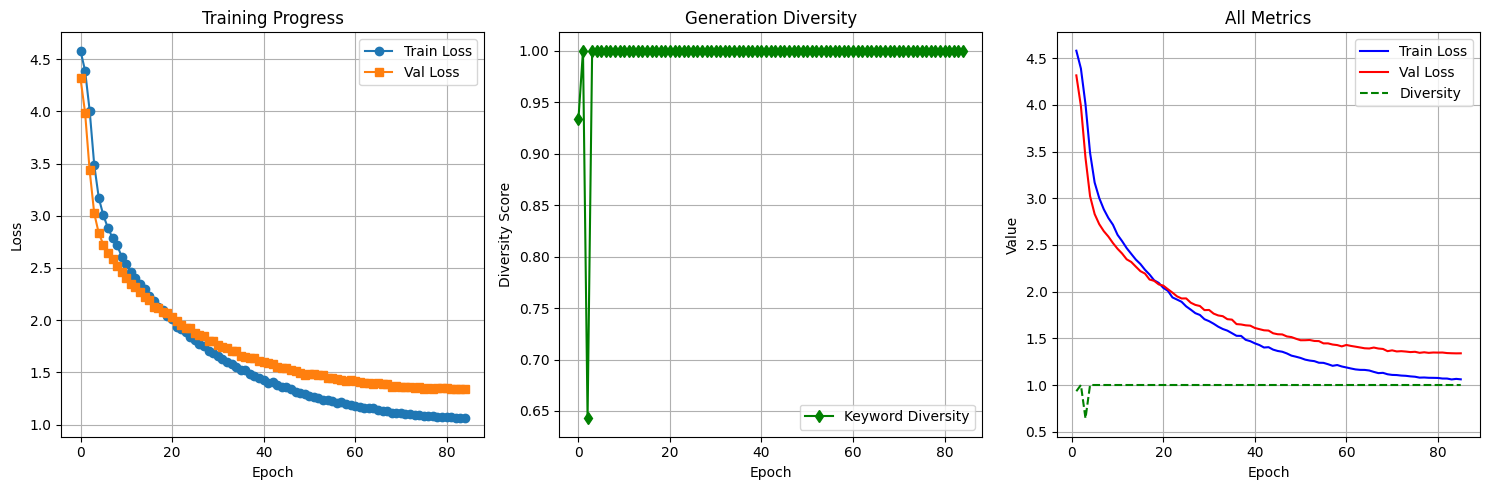


✅ LoRA Training complete!

🧪 Testing the LoRA trained model...
Loading LoRA model from /content/drive/MyDrive/pinterest-flan-t5-lora-improved-dataset-no-stopping-augmented-best...
✅ LoRA model loaded successfully!

📌 James Bond (Spy)

Variation 1:
Keywords: british spy fiction moodboard | vintage spy glasses | suave gentleman style | flying saucers | red-blue hoodie | bbm security | futuristic spy suits | world war I aesthetics
Visual Score: 3.00
Pinterest Score: 5.00

📌 Queen Elizabeth II (Queen)

Variation 1:
Keywords: british monarchy aesthetics | golden age of britain | coronation gowns moodboard | royal parlors ambience | regal diplomacy vibe | long-lasting loyalty symbolism | black mourning dress | red-white-blue color scheme | 1960s england ambience
Visual Score: 4.00
Pinterest Score: 4.00

📌 Florence Nightingale (Nurse)

Variation 1:
Keywords: 19th century england aesthetics | wartime care aesthetic | vintage nursing chairs | grimy gowns moodboard | Victorian parlors vibe | st

In [10]:
def main():
    """Main execution function"""

    set_seed(Config.SEED)
    mount_drive()

    trainer = PinterestLoRATrainer(Config)

    train_data, val_data = trainer.prepare_data(Config.DATASET_PATH)

    # Train the model
    history = trainer.train(train_data, val_data)
    print("\n✅ LoRA Training complete!")

    # Test the model
    print("\n🧪 Testing the LoRA trained model...")

    generator = PinterestLoRAGenerator(f"{Config.MODEL_SAVE_PATH}-best")

    test_cases = [
       {
        "personality_name": "James Bond",
        "role": "Spy",
        "culture_region": "Britain",
        "time_period": "Late 20th century",
        "bio": "James Bond is a fictional British secret agent created by Ian Fleming. Known as 007, he's famous for his suave demeanor, high-tech gadgets, and daring missions to thwart global threats."
      },
      {
        "personality_name": "Queen Elizabeth II",
        "role": "Queen",
        "culture_region": "Britain",
        "time_period": "20th-21st Century",
        "bio": "Queen Elizabeth II was the longest-reigning British monarch, serving from 1952 to 2022. She was a symbol of continuity, stability, and public service during a time of major social and political change."
      },
      {
        "personality_name": "Florence Nightingale",
        "role": "Nurse",
        "culture_region": "English",
        "time_period": "19th Century",
        "bio": "Florence Nightingale was a pioneering English nurse who revolutionized hospital care during the Crimean War. She's known as the founder of modern nursing and a major advocate for sanitary medical practices."
      }
    ]

    for test_case in test_cases:
        result = generator.generate(**test_case)

        print(f"\n📌 {result['personality']} ({result['role']})")
        for i, variation in enumerate(result['variations'], 1):
            print(f"\nVariation {i}:")
            print(f"Keywords: {variation['keywords']}")
            print(f"Visual Score: {variation['quality']['visual_score']:.2f}")
            print(f"Pinterest Score: {variation['quality']['pinterest_score']:.2f}")

    print("\n🎉 LoRA Pipeline complete! Your model is ready for Pinterest keyword generation.")

if __name__ == "__main__":
    main()

## 1.10 Trained Model Testing With Additional Test Cases

In [12]:
    print("\n🧪 Testing the trained model...")

    generator = PinterestLoRAGenerator(f"{Config.MODEL_SAVE_PATH}-final")

    test_cases = [
        {
            "personality_name": "Spider-Man",
            "role": "Superhero",
            "culture_region": "American",
            "time_period": "20th-21st Century",
            "bio": "Spider-Man, also known as Peter Parker, is a fictional American superhero created by Stan Lee and Steve Ditko for Marvel Comics. A teenager bitten by a radioactive spider, Peter gains spider-like abilities including super strength, agility, and the power to cling to walls. Using his scientific brilliance, he invents web-shooters and takes on the mantle of Spider-Man to fight crime in New York City. Known for the iconic motto 'With great power comes great responsibility,' Spider-Man is celebrated for balancing heroism with the struggles of everyday life."
        },
        {
            "personality_name": "Iron Man",
            "role": "Superhero / Inventor",
            "culture_region": "American",
            "time_period": "20th-21st Century",
            "bio": "Iron Man, or Tony Stark, is a fictional American billionaire industrialist and genius inventor who dons a powered suit of armor to become a superhero. Created by Stan Lee, Larry Lieber, Don Heck, and Jack Kirby for Marvel Comics, Stark begins his transformation after being injured and captured during war. He creates a high-tech suit to escape and later refines it to fight global threats. Known for his intelligence, wit, and evolution from a self-absorbed weapons manufacturer to a self-sacrificing hero, Iron Man is a cornerstone of modern superhero mythology."
        },
        {
            "personality_name": "Mother Teresa",
            "role": "Missionary",
            "culture_region": "Albanian-Indian",
            "time_period": "20th Century",
            "bio": "Mother Teresa was a Catholic missionary known for her unwavering service to the poor, sick, and dying in Kolkata, India. Born in Albania, she founded the Missionaries of Charity, a religious congregation that expanded globally. She became an international symbol of compassion, winning the Nobel Peace Prize in 1979. Despite criticism from some quarters, she remained committed to her mission of serving 'the poorest of the poor' and was canonized as a saint in 2016 for her humanitarian work."
        },
        {
            "personality_name": "Al-Ghazali",
            "role": "Philosopher / Theologian",
            "culture_region": "Persian-Islamic",
            "time_period": "11th-12th Century",
            "bio": "Al-Ghazali was a Persian Islamic scholar, philosopher, and theologian who played a pivotal role in the development of Islamic thought. His work synthesized Sufism with mainstream Islamic theology, and his critiques of philosophy reshaped the intellectual landscape of the Muslim world. His most famous work, 'The Incoherence of the Philosophers,' challenged the ideas of earlier Islamic philosophers like Avicenna. Revered as a renewer of the faith (mujaddid), Al-Ghazali remains one of the most influential figures in Islamic history."
        },
        {
            "personality_name": "Napoleon Bonaparte",
            "role": "Military Leader / Emperor",
            "culture_region": "French",
            "time_period": "18th-19th Century",
            "bio": "Napoleon Bonaparte was a French military general who rose to prominence during the French Revolution and became Emperor of France. Known for his strategic brilliance and ambitious reforms, he expanded French influence across Europe before his eventual defeat and exile. He implemented the Napoleonic Code, which influenced legal systems worldwide, and modernized administrative, military, and educational structures. Despite his downfall at Waterloo, Napoleon remains one of the most studied military leaders in history."
        }
    ]



    for test_case in test_cases:
        result = generator.generate(**test_case)

        print(f"\n📌 {result['personality']} ({result['role']})")
        for i, variation in enumerate(result['variations'], 1):
            print(f"\nVariation {i}:")
            print(f"Keywords: {variation['keywords']}")
            print(f"Visual Score: {variation['quality']['visual_score']:.2f}")
            print(f"Pinterest Score: {variation['quality']['pinterest_score']:.2f}")

    print("\n🎉 Pipeline complete! The model is ready for Pinterest keyword generation.")




🧪 Testing the trained model...
Loading LoRA model from /content/drive/MyDrive/pinterest-flan-t5-lora-improved-dataset-no-stopping-augmented-final...
✅ LoRA model loaded successfully!

📌 Spider-Man (Superhero)

Variation 1:
Keywords: spiderman aesthetics | red-white-blue color scheme | web-shooters moodboard | nyc skyline ambience | Spider-Man core | modern american urban heroism | spiderwebs theme | retro comic book aesthetic | New York City aesthetic
Visual Score: 3.00
Pinterest Score: 3.00

📌 Iron Man (Superhero / Inventor)

Variation 1:
Keywords: iron man suit aesthetics | high-tech innovation | futuristic heroism | 1950s fashion moodboard | sleek steel suits | industrial robot aesthetic | Iron Man aesthetic
Visual Score: 3.00
Pinterest Score: 3.00

📌 Mother Teresa (Missionary)

Variation 1:
Keywords: humanitarian spirit | nun aesthetics | missionaries of charity | christianity moodboard | laurel crown ambience | saint symbolism | Kolkata miracle flowers | maroon mourning rituals
V

# 2 Deploying to HuggingFace

## 2.1 Installing Dependencies

In [1]:
!pip install huggingface_hub peft -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.9 MB/s eta 0:00:00


## 2.2 Importing Packages

In [11]:
import time
import os
import shutil
import traceback
from pathlib import Path

import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    GenerationConfig,
    pipeline
)
from peft import PeftModel, PeftConfig
from huggingface_hub import (
    HfApi,
    notebook_login,
    create_repo,
    delete_repo,
    repo_exists
)

## 2.3 Deployment Configuration

In [18]:
class DeployConfig:
    """Enhanced deployment configuration"""

    LORA_MODEL_PATH = "/content/drive/MyDrive/pinterest-flan-t5-lora-improved-dataset-no-stopping-augmented-final"
    BASE_MODEL_NAME = "google/flan-t5-base"

    HF_USERNAME = "Amama02"
    MODEL_NAME = "pinterest-personality-keywords-v4"

    PRIVATE_REPO = False
    FORCE_RECREATE = True

    USE_SAFETENSORS = True
    TORCH_DTYPE = torch.float16 if torch.cuda.is_available() else torch.float32

    GENERATION_PARAMS = {
        "max_length": 300,
        "num_beams": 8,
        "temperature": 0.9,
        "do_sample": True,
        "top_p": 0.95,
        "repetition_penalty": 2.0,
        "length_penalty": 1.2,
        "early_stopping": True,
        "no_repeat_ngram_size": 2,
    }

    @property
    def repo_name(self):
        return f"{self.HF_USERNAME}/{self.MODEL_NAME}"

    @property
    def repo_url(self):
        return f"https://huggingface.co/{self.repo_name}"

config = DeployConfig()

print("🚀 Enhanced LoRA Deployment Configuration")
print("=" * 60)
print(f"📁 LoRA Model Path: {config.LORA_MODEL_PATH}")
print(f"🤗 Target Repository: {config.repo_name}")
print(f"🌐 Repository URL: {config.repo_url}")
print(f"🔒 Private Repository: {config.PRIVATE_REPO}")
print(f"🔄 Force Recreate: {config.FORCE_RECREATE}")


🚀 Enhanced LoRA Deployment Configuration
📁 LoRA Model Path: /content/drive/MyDrive/pinterest-flan-t5-lora-improved-dataset-no-stopping-augmented-final
🤗 Target Repository: Amama02/pinterest-personality-keywords-v4
🌐 Repository URL: https://huggingface.co/Amama02/pinterest-personality-keywords-v4
🔒 Private Repository: False
🔄 Force Recreate: True


## 2.4 HuggingFace Authentication

In [4]:
def authenticate_huggingface():
    """HuggingFace authentication with retry"""

    max_retries = 3
    for attempt in range(max_retries):
        try:
            print(f"🔐 HuggingFace Authentication (Attempt {attempt + 1}/{max_retries})")
            notebook_login()

            api = HfApi()
            user_info = api.whoami()
            print(f"✅ Successfully authenticated as: {user_info['name']}")

            if user_info['name'] != config.HF_USERNAME:
                print(f"⚠️ Warning: Logged in as '{user_info['name']}' but config shows '{config.HF_USERNAME}'")
                response = input("Continue anyway? (y/n): ")
                if response.lower() != 'y':
                    return False

            return True

        except Exception as e:
            print(f"❌ Authentication failed: {e}")
            if attempt < max_retries - 1:
                print("Retrying in 5 seconds...")
                time.sleep(5)
            else:
                print("❌ Authentication failed after all retries")
                return False

    return False


## 2.5 Midel Validation and Loading

In [5]:
def validate_and_load_models():
    """Validate paths and load models with comprehensive error handling"""

    print("\n📋 Model Validation and Loading")
    print("=" * 50)

    # Check if LoRA model exists
    if not os.path.exists(config.LORA_MODEL_PATH):
        print(f"❌ LoRA model not found at: {config.LORA_MODEL_PATH}")
        print("Available paths in drive:")
        try:
            drive_path = "/content/drive/MyDrive"
            for item in os.listdir(drive_path):
                if "lora" in item.lower() or "pinterest" in item.lower():
                    print(f"  📁 {os.path.join(drive_path, item)}")
        except:
            pass
        return None, None, None

    print(f"✅ LoRA model found at: {config.LORA_MODEL_PATH}")

    try:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"🖥️ Using device: {device}")

        print("📝 Loading tokenizer...")
        tokenizer = AutoTokenizer.from_pretrained(config.LORA_MODEL_PATH)
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
        print("✅ Tokenizer loaded successfully")

        print(f"🧠 Loading base model: {config.BASE_MODEL_NAME}")
        base_model = AutoModelForSeq2SeqLM.from_pretrained(
            config.BASE_MODEL_NAME,
            torch_dtype=config.TORCH_DTYPE,
            device_map="auto" if torch.cuda.is_available() else None,
            trust_remote_code=True
        )
        print("✅ Base model loaded successfully")

        print("🔧 Loading LoRA configuration...")
        peft_config = PeftConfig.from_pretrained(config.LORA_MODEL_PATH)
        print(f"✅ LoRA config loaded - Type: {peft_config.peft_type}, Rank: {peft_config.r}")

        print("🔀 Loading and merging LoRA adapter...")
        lora_model = PeftModel.from_pretrained(base_model, config.LORA_MODEL_PATH)
        merged_model = lora_model.merge_and_unload()
        print("✅ LoRA merged successfully")

        generation_config = GenerationConfig(
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
            bos_token_id=tokenizer.bos_token_id if hasattr(tokenizer, 'bos_token_id') else None,
            **config.GENERATION_PARAMS
        )

        print("✅ All models loaded and validated successfully")
        return merged_model, tokenizer, generation_config

    except Exception as e:
        print(f"❌ Model loading failed: {str(e)}")
        print("Full error traceback:")
        traceback.print_exc()
        return None, None, None

## 2.6 Managing Repo

In [6]:
def manage_repository():
    """Repository management with deletion and recreation"""

    print(f"\n📦 Repository Management: {config.repo_name}")
    print("=" * 50)

    api = HfApi()

    try:
        repo_exists_flag = repo_exists(config.repo_name)
        print(f"📊 Repository exists: {repo_exists_flag}")

        if repo_exists_flag:
            if config.FORCE_RECREATE:
                print("🗑️ Force recreate enabled - deleting existing repository...")
                try:
                    delete_repo(config.repo_name, repo_type="model")
                    print("✅ Repository deleted successfully")
                    time.sleep(2)  # Wait a moment
                except Exception as e:
                    print(f"⚠️ Delete warning (might be already deleted): {e}")
            else:
                print("⚠️ Repository exists and force recreate is disabled")
                response = input("Delete and recreate? (y/n): ")
                if response.lower() == 'y':
                    delete_repo(config.repo_name, repo_type="model")
                    print("✅ Repository deleted")
                    time.sleep(2)
                else:
                    print("📝 Will update existing repository")

        print("🆕 Creating repository...")
        repo_url = create_repo(
            config.repo_name,
            private=config.PRIVATE_REPO,
            exist_ok=True,
            repo_type="model"
        )
        print(f"✅ Repository created/confirmed: {repo_url}")
        return True

    except Exception as e:
        print(f"❌ Repository management failed: {str(e)}")
        traceback.print_exc()
        return False


## 2.7 Model Card

In [7]:
def create_enhanced_model_card():
    """Create a comprehensive model card with examples"""

    model_card = f"""---
language: en
license: apache-2.0
base_model: {config.BASE_MODEL_NAME}
tags:
- text2text-generation
- pinterest
- keywords
- personality
- fine-tuned
- lora
- flan-t5
library_name: transformers
pipeline_tag: text2text-generation
widget:
- text: "Generate Pinterest keywords for Cleopatra - Culture: Egyptian | Role: Royalty | Period: Ancient Egypt - Keywords should be visual, searchable on Pinterest, and capture their aesthetic essence. The Culture, Role, Period and bio give important information about the personality. Take them into account when generating keywords"
  example_title: "Cleopatra Keywords"
- text: "Generate Pinterest keywords for Leonardo da Vinci - Culture: Italian | Role: Polymath | Period: Renaissance - Keywords should be visual, searchable on Pinterest, and capture their aesthetic essence. The Culture, Role, Period and bio give important information about the personality. Take them into account when generating keywords"
  example_title: "Leonardo da Vinci Keywords"
---

# Pinterest Personality Keywords Generator

🎨 **Fine-tuned FLAN-T5 model for generating Pinterest-optimized keywords for historical and fictional personalities.**

This model was fine-tuned using LoRA (Low-Rank Adaptation) to generate visually appealing, searchable Pinterest keywords based on personality information.

## 🚀 Quick Start

### Using Transformers Pipeline
```python
from transformers import pipeline

# Load the model
generator = pipeline("text2text-generation", model="{config.repo_name}")

# Generate keywords
input_text = "Generate Pinterest keywords for Marie Curie - Culture: Polish-French | Role: Scientist | Period: Early 20th Century - Keywords should be visual, searchable on Pinterest, and capture their aesthetic essence. The Culture, Role, Period and bio give important information about the personality. Take them into account when generating keywords"

result = generator(
    input_text,
    max_length=300,
    num_beams=8,
    temperature=0.9,
    do_sample=True,
    top_p=0.95,
    repetition_penalty=2.0,
    length_penalty=1.2,
    no_repeat_ngram_size=2
)

print(result[0]['generated_text'])
```

### Using Direct Model Loading
```python
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("{config.repo_name}")
model = AutoModelForSeq2SeqLM.from_pretrained("{config.repo_name}")

# Prepare input
input_text = "Generate Pinterest keywords for Frida Kahlo - Culture: Mexican | Role: Artist | Period: 20th Century - Keywords should be visual, searchable on Pinterest, and capture their aesthetic essence. The Culture, Role, Period and bio give important information about the personality. Take them into account when generating keywords"

# Tokenize and generate
inputs = tokenizer(input_text, return_tensors="pt", max_length=256, truncation=True)
outputs = model.generate(
    **inputs,
    max_length=300,
    num_beams=8,
    temperature=0.9,
    do_sample=True,
    top_p=0.95,
    repetition_penalty=2.0,
    length_penalty=1.2,
    early_stopping=True,
    no_repeat_ngram_size=2
)

keywords = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(keywords)
```

## 📝 Input Format

The model expects input in this specific format:

```
Generate Pinterest keywords for [PERSONALITY_NAME] - Culture: [CULTURE] | Role: [ROLE] | Period: [TIME_PERIOD] | Bio: [BIOGRAPHY] - Keywords should be visual, searchable on Pinterest, and capture their aesthetic essence. The Culture, Role, Period and bio give important information about the personality. Take them into account when generating keywords
```

### Required Fields:
- **PERSONALITY_NAME**: Name of the person
- **Culture**: Cultural background or nationality
- **Role**: Profession, title, or main role
- **Period**: Historical time period
- **Bio**: (Optional) Brief biography

## 🎯 Example Outputs

| Input | Generated Keywords |
|-------|-------------------|
| **Cleopatra** (Egyptian Royalty, Ancient Egypt) | "Egyptian queen aesthetic, ancient Egypt fashion, Cleopatra makeup, pharaoh style, golden jewelry, Egyptian mythology, ancient beauty, royal Egyptian, hieroglyphics, Egyptian art" |
| **Leonardo da Vinci** (Italian Polymath, Renaissance) | "Renaissance art, Italian genius, classical paintings, Renaissance fashion, vintage sketches, Italian Renaissance, Renaissance architecture, classical art history" |
| **Marie Curie** (Polish-French Scientist, Early 20th Century) | "vintage science, female scientist aesthetic, laboratory vintage, early 1900s fashion, women in science, vintage academic, scientific discovery, vintage portraits" |

## ⚙️ Generation Parameters

The model is optimized with these generation settings:

- **max_length**: 300
- **num_beams**: 8
- **temperature**: 0.9
- **top_p**: 0.95
- **repetition_penalty**: 2.0
- **length_penalty**: 1.2
- **no_repeat_ngram_size**: 2

## 🔧 Technical Details

- **Base Model**: {config.BASE_MODEL_NAME}
- **Fine-tuning Method**: LoRA (Low-Rank Adaptation)
- **LoRA Rank**: 16
- **Target Modules**: ["q", "v", "k", "o", "wi", "wo"]
- **Training Data**: Historical and fictional personalities dataset
- **Task**: Seq2Seq text generation

## 📊 Model Performance

The model has been optimized for:
- ✅ **Visual Keywords**: Generates terms that work well for image searches
- ✅ **Pinterest Optimization**: Keywords tailored for Pinterest's search algorithm
- ✅ **Cultural Sensitivity**: Respects cultural context and historical accuracy
- ✅ **Diversity**: Produces varied and creative keyword combinations

## 🚫 Limitations

- Specifically designed for Pinterest keyword generation
- May not perform well on other text generation tasks
- Limited to personalities with sufficient historical/cultural context
- Requires specific input format for optimal results


"""
    return model_card


## 2.8 Model Deployment Function

In [8]:
def deploy_model_with_retry():
    """Deploy model with retry logic and error handling"""

    print(f"\n📤 Enhanced Model Deployment")
    print("=" * 50)

    # Load models
    merged_model, tokenizer, generation_config = validate_and_load_models()
    if merged_model is None:
        return False

    # Manage repository
    if not manage_repository():
        return False

    max_retries = 3
    api = HfApi()

    for attempt in range(max_retries):
        try:
            print(f"\n📤 Upload Attempt {attempt + 1}/{max_retries}")

            # Create temporary directory for uploads
            temp_dir = Path("./temp_model_deploy")
            temp_dir.mkdir(exist_ok=True)

            # Save model locally first
            print("💾 Saving model locally...")
            merged_model.save_pretrained(
                temp_dir,
                safe_serialization=config.USE_SAFETENSORS,
                max_shard_size="2GB"
            )

            print("💾 Saving tokenizer locally...")
            tokenizer.save_pretrained(temp_dir)

            print("💾 Saving generation config locally...")
            generation_config.save_pretrained(temp_dir)

            # Create model card
            model_card = create_enhanced_model_card()
            with open(temp_dir / "README.md", "w", encoding="utf-8") as f:
                f.write(model_card)

            # Create additional metadata
            metadata = {
                "model_info": {
                    "base_model": config.BASE_MODEL_NAME,
                    "fine_tuning_method": "LoRA",
                    "generation_parameters": config.GENERATION_PARAMS,
                    "deployment_date": time.strftime("%Y-%m-%d %H:%M:%S"),
                    "torch_dtype": str(config.TORCH_DTYPE)
                }
            }

            with open(temp_dir / "model_metadata.json", "w") as f:
                json.dump(metadata, f, indent=2)

            # Upload to Hub using transformers' push_to_hub
            print("🚀 Uploading model to Hub...")
            merged_model.push_to_hub(
                config.repo_name,
                private=config.PRIVATE_REPO,
                safe_serialization=config.USE_SAFETENSORS,
                max_shard_size="2GB"
            )

            print("🚀 Uploading tokenizer to Hub...")
            tokenizer.push_to_hub(config.repo_name, private=config.PRIVATE_REPO)

            # Upload additional files
            print("📋 Uploading additional files...")
            files_to_upload = [
                ("README.md", "README.md"),
                ("generation_config.json", "generation_config.json"),
                ("model_metadata.json", "model_metadata.json")
            ]

            for local_file, repo_file in files_to_upload:
                local_path = temp_dir / local_file
                if local_path.exists():
                    api.upload_file(
                        path_or_fileobj=str(local_path),
                        path_in_repo=repo_file,
                        repo_id=config.repo_name,
                        repo_type="model"
                    )
                    print(f"  ✅ Uploaded {repo_file}")

            # Cleanup
            shutil.rmtree(temp_dir, ignore_errors=True)

            print(f"✅ Model successfully deployed!")
            print(f"🌐 Model URL: {config.repo_url}")
            return True

        except Exception as e:
            print(f"❌ Upload attempt {attempt + 1} failed: {str(e)}")
            if attempt < max_retries - 1:
                print("⏳ Waiting 10 seconds before retry...")
                time.sleep(10)
            else:
                print("❌ All upload attempts failed")
                traceback.print_exc()

    return False


## 2.9 Main Function

In [9]:
def main():
    """Main execution function with comprehensive error handling"""

    print("🚀 ENHANCED LORA MODEL DEPLOYMENT")
    print("=" * 60)
    print(f"🎯 Target: {config.repo_name}")
    print(f"🌐 URL: {config.repo_url}")
    print("=" * 60)

    # Step 1: Authenticate
    if not authenticate_huggingface():
        print("❌ Authentication failed - cannot proceed")
        return False

    # Step 2: Deploy model
    if not deploy_model_with_retry():
        print("❌ Deployment failed")
        return False

    # Final success message
    print("\n" + "🎉"*20)
    print("🎉 DEPLOYMENT SUCCESSFUL! 🎉")
    print("🎉"*20)
    print(f"\n📍 The model is live at: {config.repo_url}")

    return True

## 2.10 Main Function Execution

In [20]:
if __name__ == "__main__":
    # Validate configuration before starting
    print("🔍 Pre-deployment Validation")
    print("=" * 40)

    print(f"✅ Username configured: {config.HF_USERNAME}")

    # Check if LoRA path exists
    if os.path.exists(config.LORA_MODEL_PATH):
        print(f"✅ LoRA model path exists: {config.LORA_MODEL_PATH}")
    else:
        print(f"❌ LoRA model path not found: {config.LORA_MODEL_PATH}")

    # Ask for confirmation
    print(f"\n📋 Ready to deploy to: {config.repo_name}")
    print(f"🔄 Force recreate: {config.FORCE_RECREATE}")

    # Run deployment
    if config.HF_USERNAME != "your-username" and os.path.exists(config.LORA_MODEL_PATH):
        success = main()
        if success:
            print("\n🎊 Deployment pipeline completed successfully!")
        else:
            print("\n💥 Deployment pipeline failed - check errors above")
    else:
        print("\n⚠️ Please fix configuration issues before deploying")

🔍 Pre-deployment Validation
✅ Username configured: Amama02
✅ LoRA model path exists: /content/drive/MyDrive/pinterest-flan-t5-lora-improved-dataset-no-stopping-augmented-final

📋 Ready to deploy to: Amama02/pinterest-personality-keywords-v4
🔄 Force recreate: True
🚀 ENHANCED LORA MODEL DEPLOYMENT
🎯 Target: Amama02/pinterest-personality-keywords-v4
🌐 URL: https://huggingface.co/Amama02/pinterest-personality-keywords-v4
🔐 HuggingFace Authentication (Attempt 1/3)


✅ Successfully authenticated as: Amama02

📤 Enhanced Model Deployment

📋 Model Validation and Loading
✅ LoRA model found at: /content/drive/MyDrive/pinterest-flan-t5-lora-improved-dataset-no-stopping-augmented-final
🖥️ Using device: cuda
📝 Loading tokenizer...
✅ Tokenizer loaded successfully
🧠 Loading base model: google/flan-t5-base


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

✅ Base model loaded successfully
🔧 Loading LoRA configuration...
✅ LoRA config loaded - Type: PeftType.LORA, Rank: 16
🔀 Loading and merging LoRA adapter...
✅ LoRA merged successfully
✅ All models loaded and validated successfully

📦 Repository Management: Amama02/pinterest-personality-keywords-v4
📊 Repository exists: False
🆕 Creating repository...
✅ Repository created/confirmed: https://huggingface.co/Amama02/pinterest-personality-keywords-v4

📤 Upload Attempt 1/3
💾 Saving model locally...
💾 Saving tokenizer locally...
💾 Saving generation config locally...
🚀 Uploading model to Hub...


Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  /tmp/tmpjnargk4e/model.safetensors    :   0%|          |  551kB /  571MB            

🚀 Uploading tokenizer to Hub...


README.md: 0.00B [00:00, ?B/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  /tmp/tmpghxy36qw/spiece.model         :  75%|#######4  |  593kB /  792kB            

📋 Uploading additional files...
  ✅ Uploaded README.md
  ✅ Uploaded generation_config.json
  ✅ Uploaded model_metadata.json
✅ Model successfully deployed!
🌐 Model URL: https://huggingface.co/Amama02/pinterest-personality-keywords-v4

🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
🎉 DEPLOYMENT SUCCESSFUL! 🎉
🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉

📍 The model is live at: https://huggingface.co/Amama02/pinterest-personality-keywords-v4

🎊 Deployment pipeline completed successfully!


# 3 Testing Deployed HuggingFace Model

## 3.1 Imprting Packages

In [22]:
import os
import time
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    pipeline
)

## 3.2 Configuration

In [23]:
REPO_NAME = "Amama02/pinterest-personality-keywords-v4"

## 3.3 HuggingFace Model Testing Class

In [24]:
class ModelTester:
    """model tester"""

    def __init__(self, repo_name: str):
        self.repo_name = repo_name
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = None
        self.tokenizer = None

    def load_model(self):
        """Load model with proper token configuration"""
        print(f"📥 Loading model from Hub: {self.repo_name}")

        try:
            self.tokenizer = AutoTokenizer.from_pretrained(self.repo_name)

            self.model = AutoModelForSeq2SeqLM.from_pretrained(self.repo_name)
            self.model = self.model.to(self.device)

            if self.tokenizer.pad_token is None:
                self.tokenizer.pad_token = self.tokenizer.eos_token

            if self.model.config.decoder_start_token_id is None:
                self.model.config.decoder_start_token_id = self.tokenizer.pad_token_id

            if not hasattr(self.model.config, 'bos_token_id') or self.model.config.bos_token_id is None:
                self.model.config.bos_token_id = self.tokenizer.pad_token_id

            print("✅ Model loaded and configured successfully!")
            print(f"🖥️ Using device: {self.device}")
            return True

        except Exception as e:
            print(f"❌ Error loading model: {str(e)}")
            return False

    def generate_keywords(self, personality_name: str, role: str = "",
                         culture_region: str = "", time_period: str = "", bio: str = ""):
        """Generate keywords with fixed token configuration"""

        if self.model is None or self.tokenizer is None:
            raise ValueError("Model not loaded. Call load_model() first.")

        # Build prompt in same format as original
        input_parts = [f"Generate Pinterest keywords for {personality_name}"]
        context_parts = []

        if culture_region:
            context_parts.append(f"Culture: {culture_region}")
        if role:
            context_parts.append(f"Role: {role}")
        if time_period:
            context_parts.append(f"Period: {time_period}")
        if bio:
            context_parts.append(f"Bio: {bio}")

        if context_parts:
            input_parts.append(" | ".join(context_parts))

        input_parts.append("Keywords should be visual, searchable on Pinterest, and capture their aesthetic essence. The Culture, Role, Period and bio give important information about the personality. Take them into account when generating keywords")

        prompt = " - ".join(input_parts)

        inputs = self.tokenizer(
            prompt,
            return_tensors="pt",
            max_length=256,
            truncation=True,
            padding=True
        )

        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_length=300,
                num_beams=8,
                temperature=0.9,
                do_sample=True,
                top_p=0.95,
                repetition_penalty=2.0,
                length_penalty=1.2,
                early_stopping=True,
                no_repeat_ngram_size=2,
                pad_token_id=self.tokenizer.pad_token_id,
                eos_token_id=self.tokenizer.eos_token_id,
                decoder_start_token_id=self.model.config.decoder_start_token_id,
                use_cache=True
            )

        # Decode output
        generated_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        return generated_text

    def run_comprehensive_test(self):
        """Run comprehensive tests with fixed token handling"""

        test_cases = [
          {
            "personality_name": "Cleopatra",
            "role": "Queen",
            "culture_region": "Egyptian",
            "time_period": "Classical Antiquity",
            "bio": "Cleopatra was the last active ruler of the Ptolemaic Kingdom of Egypt. Known for her intelligence and political acumen, she skillfully navigated Roman power struggles, forming alliances with Caesar and Antony. Her reign aimed to maintain Egypt's autonomy and prosperity, though ultimately ended with Roman conquest and her own death."
          },
          {
            "personality_name": "Leonardo da Vinci",
            "role": "Polymath",
            "culture_region": "Italian",
            "time_period": "Renaissance",
            "bio": "Leonardo da Vinci was a Renaissance polymath whose work spanned painting, anatomy, and engineering. He created iconic artworks like the Mona Lisa and The Last Supper and conceptualized inventions centuries ahead of his time."
          },
          {
            "personality_name": "Frida Kahlo",
            "role": "Painter",
            "culture_region": "Mexican",
            "time_period": "20th Century",
            "bio": "Frida Kahlo was a Mexican painter known for symbolic self-portraits exploring pain, identity, and womanhood. Influenced by Mexican folk art and personal suffering, her bold visual language made her a lasting icon of feminist and cultural expression."
          },
          {
            "personality_name": "Marie Curie",
            "role": "Scientist",
            "culture_region": "Polish-French",
            "time_period": "Early 20th Century",
            "bio": "Marie Curie was a physicist and chemist who discovered polonium and radium, developed the theory of radioactivity, and was the first woman to win a Nobel Prize. Her research revolutionized physics, chemistry, and medical treatment of cancer."
          }
        ]

        print(f"\n🧪 Running {len(test_cases)} test cases...")
        print("=" * 80)

        for i, test_case in enumerate(test_cases, 1):
            print(f"\n🎭 Test {i}: {test_case['personality_name']}")
            print(f"📝 Context: {test_case['role']} | {test_case['culture_region']} | {test_case['time_period']}")
            print(f"📖 Bio: {test_case['bio']}")

            try:
                start_time = time.time()
                keywords = self.generate_keywords(**test_case)
                generation_time = time.time() - start_time

                print(f"\n🎯 Generated Keywords:")
                print(f"   {keywords}")
                print(f"⏱️ Generation Time: {generation_time:.2f}s")

                # Count and analyze keywords
                keyword_list = [k.strip() for k in keywords.split(',') if k.strip()]
                print(f"📊 Keyword Count: {len(keyword_list)}")

                # Show first few keywords for quality check
                if len(keyword_list) > 0:
                    print(f"🔍 Sample Keywords: {', '.join(keyword_list[:5])}...")

                print("-" * 80)

            except Exception as e:
                print(f"❌ Error generating keywords: {str(e)}")
                print("-" * 80)

        print(f"\n✅ All tests completed!")

## 3.4 Usage Functions

In [28]:
def run_tests():
    """Run tests"""

    print("🔧 DEPLOYED MODEL TESTING")
    print("=" * 50)

    print(f"🎯 Testing repository: {REPO_NAME}")

    try:
        print("\n" + "="*60)
        print("CLASS-BASED TESTING")
        print("="*60)

        tester = ModelTester(REPO_NAME)
        if tester.load_model():
            tester.run_comprehensive_test()

        print("\n" + "="*60)
        print(f"\n🎉 ALL TESTS COMPLETED SUCCESSFULLY!")


    except Exception as e:
        print(f"❌ Testing failed: {str(e)}")
        import traceback
        traceback.print_exc()
if __name__ == "__main__":
    run_tests()

🔧 DEPLOYED MODEL TESTING
🎯 Testing repository: Amama02/pinterest-personality-keywords-v4

CLASS-BASED TESTING
📥 Loading model from Hub: Amama02/pinterest-personality-keywords-v4
✅ Model loaded and configured successfully!
🖥️ Using device: cuda

🧪 Running 4 test cases...

🎭 Test 1: Cleopatra
📝 Context: Queen | Egyptian | Classical Antiquity
📖 Bio: Cleopatra was the last active ruler of the Ptolemaic Kingdom of Egypt. Known for her intelligence and political acumen, she skillfully navigated Roman power struggles, forming alliances with Caesar and Antony. Her reign aimed to maintain Egypt's autonomy and prosperity, though ultimately ended with Roman conquest and her own death.

🎯 Generated Keywords:
   ancient egyptian hieroglyphic art | roman conquest moodboard | golden frescoes | Roman armor aesthetic | stone sphinx aura | classical architecture theme board | marble robes look | Ptolemaic dynasty aesthetic
⏱️ Generation Time: 1.58s
📊 Keyword Count: 1
🔍 Sample Keywords: ancient egyptian 